## Configuração do ambiente

In [1]:
# Run only on colab
# install locally using conda
!pip install shap=='0.42.1'
!pip install lime
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=5cf03bfc4ab41c8ed9e124bde6203122b677c41453cea92e5596c7b818d84620
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.cluster import KMeans
from enum import Enum
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LeakyReLU,PReLU,ELU
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from xgboost.sklearn import XGBClassifier
from sklearn import svm
import warnings

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Enumerador para o tipo de XAI a ser utilizado
class XAI(Enum):
    SHAP_Instance = 1
    SHAP_Summary = 2
    LIME = 3
    NONE = 4
# Enumerador para o tipo de Explainer a ser utilizado pelo SHAP
class SHAP_Type(Enum):
    Tree_Explainer = 1
    Kernel_Explainer = 2
    Sampling_Explainer = 3
    GPUTree_Explainer = 4
    Deep_Explainer = 5
    Gradient_Explainer = 6
    Linear_Explainer = 7
    Partition_Explainer = 8
    Permutation_Explainer = 9
    Additive_Explainer = 10

# Dataset

## Colab

In [6]:
# Run only on colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Carregando o Dataset

In [2]:
import zipfile

with zipfile.ZipFile('creditcard.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
path = 'creditcard.csv'

In [4]:
data = pd.read_csv(path, index_col=0)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Análise do dataset

In [5]:
# Mostrando as informações detalhadas do dataset incluindo valores nulos
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 284807 entries, 0.0 to 172792.0
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     284

In [6]:
# Verificando os percentuais de dados ausentes por coluna
(data.isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)

V1        0.0
V2        0.0
Amount    0.0
V28       0.0
V27       0.0
V26       0.0
V25       0.0
V24       0.0
V23       0.0
V22       0.0
V21       0.0
V20       0.0
V19       0.0
V18       0.0
V17       0.0
V16       0.0
V15       0.0
V14       0.0
V13       0.0
V12       0.0
V11       0.0
V10       0.0
V9        0.0
V8        0.0
V7        0.0
V6        0.0
V5        0.0
V4        0.0
V3        0.0
Class     0.0
dtype: float64

In [7]:
# Valores unicos por coluna
data.nunique().sort_values()

Class          2
Amount     32767
V28       275663
V27       275663
V26       275663
V25       275663
V24       275663
V23       275663
V22       275663
V21       275663
V20       275663
V19       275663
V18       275663
V17       275663
V16       275663
V1        275663
V13       275663
V12       275663
V11       275663
V10       275663
V9        275663
V8        275663
V7        275663
V6        275663
V5        275663
V4        275663
V3        275663
V2        275663
V14       275663
V15       275663
dtype: int64

In [8]:
# Informações detalhadas das variáveis numéricas
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
# Porcentagem dos casos de fraude / não fraude
print('Não Fraude:', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% do dataset')
print('Fraude:', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% do dataset')

Não Fraude: 99.83 % do dataset
Fraude: 0.17 % do dataset


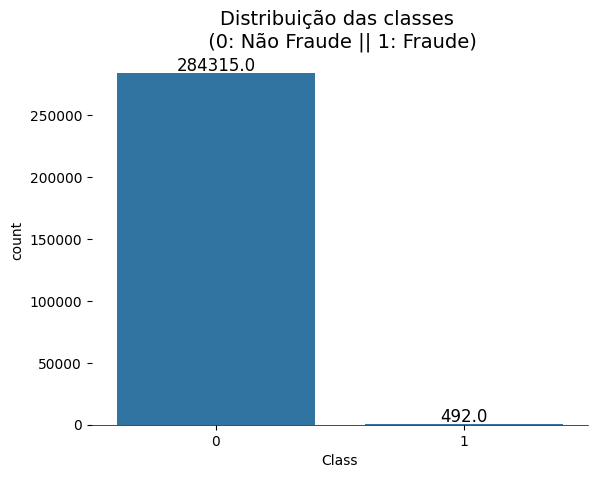

In [12]:
ax = sns.countplot(x='Class',data = data)
plt.title('Distribuição das classes \n (0: Não Fraude || 1: Fraude)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
plt.show()

In [15]:
tmp = data[['Amount','Class']].copy()
classe_0 = tmp.loc[tmp['Class'] == 0]['Amount']
classe_1 = tmp.loc[tmp['Class'] == 1]['Amount']

In [16]:
classe_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
classe_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

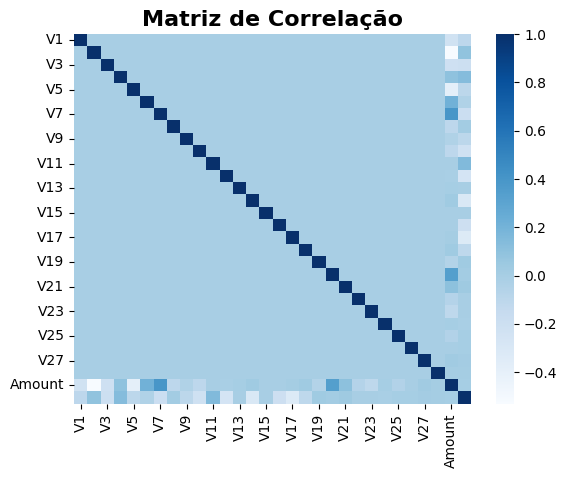

In [18]:
# Matriz de correlação (Heatmap)
# The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.
le = LabelEncoder()
tmp_data = data

dataplot = sns.heatmap(tmp_data.corr(), cmap="Blues")
plt.title("Matriz de Correlação", fontsize=16, fontweight='bold')
plt.show()

In [19]:
# Comparação de pares em relação as classes
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cols = ['Class', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
              'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
              'isFlaggedFraud']
    g = sns.pairplot(tmp_data[cols],hue = 'Class', palette='magma', diag_kind='kde')
    # title
    g._legend.set_title('Classes')
    # replace labels
    new_labels = ['Não Fraude', 'Fraude']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    # Ajustando a legenda
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle('Valores em relação as Classes (Não Fraude / Fraude)')
    sns.move_legend(g, "upper center", bbox_to_anchor=(0.75, 1))
    g

KeyError: "['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'] not in index"

## Ajustes do dataset

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def VIF(X): 
    # VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 
  
    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                            for i in range(len(X.columns))] 
  
    print(vif_data.sort_values(by=['VIF'], ascending=False))

In [28]:
VIF(data)

   feature       VIF
22   Class  1.719867
10     V17  1.183001
7      V14  1.158006
5      V12  1.116733
3      V10  1.091013
9      V16  1.066351
21  Amount  1.066219
4      V11  1.041183
0       V4  1.040107
11     V18  1.022456
2       V9  1.018351
13     V21  1.013550
15     V23  1.012045
1       V8  1.010705
12     V19  1.005023
14     V22  1.003980
17     V25  1.002185
19     V27  1.001329
20     V28  1.000258
16     V24  1.000114
6      V13  1.000062
18     V26  1.000044
8      V15  1.000039


In [27]:
data = data.drop(['V2', 'V7', 'V5', 'V20', 'V3', 'V1', 'V6'], axis=1)

In [29]:
# Splitting Features and Target
X = data.drop('Class', axis=1)
y = data['Class']

X.head()

,V4,V8,V9,V10,V11,V12,V13,V14,V15,V16,...,V19,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,,,,,,,,,,,,,,,,,,,,,
0.0,1.378155,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,...,0.403993,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
0.0,0.448154,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,...,-0.145783,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
1.0,0.379780,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,...,-2.261857,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
1.0,-0.863291,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,...,-1.232622,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
2.0,0.403034,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,...,0.803487,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Divisão de dados para treinamento e teste

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Funções

## Helpers

### Classification Report

In [31]:
# Classification Report
def class_rep(y_pred, y_test):
  class_rep = classification_report(y_pred, y_test)
  print("\n########## Classification Report ##########")
  print(class_rep)

### Rˆ2 Score

In [32]:
# Rˆ2 Score
def r2_score(model, X_test, y_test):
  r2 = model.score(X_test, y_test)
  print("\n########## Rˆ2 Score ##########")
  print("Rˆ2 Score: ", r2)

### Accuracy Score

In [33]:
# Accuracy Score
def acc_score(y_pred, y_test):
  acc = accuracy_score(y_test, y_pred)
  print("\n########## Accuracy Score ##########")
  print("Acurácia: ", acc)
  return acc

### Confusion Matrix

In [34]:
# Confusion Matrix
def cm(y_pred, y_test):
  cm = confusion_matrix(y_test, y_pred)
  print("\n########## Confusion Matrix ##########")
  print(cm)
  sns.heatmap(cm, annot=True, fmt='d', cmap="magma")
  plt.xlabel('Predito')
  plt.ylabel('Real')
  plt.show()

## Técnicas de XAI

### SHAP

#### Instance

In [35]:
# SHAP Instance
def SHAP_Instance(model, X_test, type: SHAP_Type, instance: int):
    if type == SHAP_Type.Tree_Explainer:
        explainer = shap.TreeExplainer(model)
    elif type == SHAP_Type.Kernel_Explainer:
        # Todo: implementar o parametro data quando utilizar o tipo KernelExplainer
        explainer = shap.KernelExplainer(model)
    elif type == SHAP_Type.Additive_Explainer:
        explainer = shap.AdditiveExplainer(model)
    elif type == SHAP_Type.Deep_Explainer:
        explainer = shap.DeepExplainer(model)
    elif type == SHAP_Type.GPUTree_Explainer:
        explainer = shap.GPUTreeExplainer(model)
    elif type == SHAP_Type.Gradient_Explainer:
        explainer = shap.GradientExplainer(model)
    elif type == SHAP_Type.Linear_Explainer:
        explainer = shap.LinearExplainer(model)
    elif type == SHAP_Type.Partition_Explainer:
        explainer = shap.PartitionExplainer(model)
    elif type == SHAP_Type.Permutation_Explainer:
        explainer = shap.PermutationExplainer(model)
    elif type == SHAP_Type.Sampling_Explainer:
        explainer = shap.SamplingExplainer(model)
    shap_values = explainer.shap_values(X_test)
    # RF predictions plot
    shap.initjs()
    shap.force_plot(explainer.expected_value[instance], shap_values[instance][0,:], X_test.iloc[0,:], matplotlib=True)

#### Summary

In [36]:
# SHAP Instance
def SHAP_Summary(model, X_test, type: SHAP_Type):
    if type == SHAP_Type.Tree_Explainer:
        explainer = shap.TreeExplainer(model)
    elif type == SHAP_Type.Kernel_Explainer:
        # Todo: implementar o parametro data quando utilizar o tipo KernelExplainer
        explainer = shap.KernelExplainer(model)
    elif type == SHAP_Type.Additive_Explainer:
        explainer = shap.AdditiveExplainer(model)
    elif type == SHAP_Type.Deep_Explainer:
        explainer = shap.DeepExplainer(model)
    elif type == SHAP_Type.GPUTree_Explainer:
        explainer = shap.GPUTreeExplainer(model)
    elif type == SHAP_Type.Gradient_Explainer:
        explainer = shap.GradientExplainer(model)
    elif type == SHAP_Type.Linear_Explainer:
        explainer = shap.LinearExplainer(model)
    elif type == SHAP_Type.Partition_Explainer:
        explainer = shap.PartitionExplainer(model)
    elif type == SHAP_Type.Permutation_Explainer:
        explainer = shap.PermutationExplainer(model)
    elif type == SHAP_Type.Sampling_Explainer:
        explainer = shap.SamplingExplainer(model)
    shap_values = explainer.shap_values(X_test)
    # RF predictions plot
    shap.initjs()
    plt.style.use('fivethirtyeight')
    shap.summary_plot(shap_values[0], X_test, feature_names=X_test.columns, show=False)
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_xlabel("Não Fraude <===   Resultado     ===> Fraude \n valor do SHAP (impacto na saida do modelo)")
    ax.set_title("Impacto de cada feature nas predições")

### LIME

In [37]:
# Função para exibir os resultados do Lime com fundo branco
def showLIME(html: HTML):
    # Script to change the background color of the chart to white
    script = (
    """
    <body>
    <script>
    top_div.style("background", "white");
    </script>
    </body>
    """
    )
    html += script
    display(HTML(html))

In [38]:
def LIME(model, X_train, X_test):
        # class names
        class_names = ['Fraud', 'Not Fraud']
        # Get the feature names
        feature_names = list(X_train.columns)
        # Fit the Explainer on the training data set using the LimeTabularExplainer
        explainer = LimeTabularExplainer(X_train.values, feature_names =
                                 feature_names,
                                 class_names = class_names,
                                 mode = 'classification')
        exp = explainer.explain_instance(X_test.iloc[1,:],model.predict_proba)
        html = exp.as_html()
        showLIME(html)

## Técnicas de Modelagem

### Linear Regression


In [39]:
def Linear_Regression(X_train, y_train, X_test, y_test, XAI: XAI):
  linear_reg = LinearRegression().fit(X_train, y_train)
  linear_reg_pred = linear_reg.predict(X_test)
  # Evaluation
  r2_score(linear_reg, X_test, y_test)

  # retornando o modelo e predição
  return linear_reg, linear_reg_pred

### Multivariate Linear Regression

In [40]:
# Multivariate Linear Regression
def Multivariate_Linear_Regression(X_train, y_train, X_test, y_test, XAI: XAI):
  reg_grad = SGDRegressor(max_iter=5000,alpha=0)
  reg_grad.fit(X_train, y_train)
  reg_grad_pred = reg_grad.predict(X_test)
  # Evaluation
  r2_score(reg_grad, X_test, y_test)

  # retornando o modelo e predição
  return reg_grad, reg_grad_pred

### Logistic Regression

In [41]:
def Logistic_Regression(X_train, y_train, X_test, y_test, XAI: XAI):
  # Criar o modelo de regressão logística
  model_lr = LogisticRegression(random_state=42)
  model_lr.fit(X_train, y_train)

  # Fazer previsões
  y_pred_lr = model_lr.predict(X_test)

  # Evaluation
  acc_score(y_pred_lr, y_test)

  # Classification report
  class_rep(y_pred_lr, y_test)

  # Confusion Matrix
  cm(y_pred_lr, y_test)

  # retornando o modelo e predição
  return model_lr, y_pred_lr

### Kmeans

In [42]:
# Kmeans
def Kmeans(X):
  # Normalizando os dados
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
  y_kmeans = kmeans.fit_predict(X)

  # Plotando os pontos:
  plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1],
          s = 100, c = 'red', label = 'Não Fraude')
  plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1],
          s = 100, c = 'blue', label = 'Fraude')
  # Plottando os centroids:
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1],
          s = 100, c = 'yellow', label = 'Centroids')
  plt.legend()

  # retornando o modelo e predição
  return kmeans, y_kmeans

### Random Forest

In [43]:
# Random Forest
def RandomForest(X_train, y_train, X_test, y_test, max_depth, n_estimators, XAI: XAI):
    rf = RandomForestClassifier(random_state=42, max_depth=max_depth, n_estimators=n_estimators, verbose=5)
    rf.fit(X_train, y_train)

    # Prediction
    y_pred_rf = rf.predict(X_test)

    # Evaluation
    acc_score(y_pred_rf, y_test)

    # Classification report
    class_rep(y_pred_rf, y_test)

    # Confusion Matrix
    cm(y_pred_rf, y_test)

    # XAI
    if XAI.name == "SHAP_Instance":
        SHAP_Instance(rf, X_test, 2, SHAP_Type.Tree_Explainer)
    elif XAI.name == "SHAP_Summary":
        SHAP_Summary(rf, X_test, SHAP_Type.Tree_Explainer)
    elif XAI.name == "LIME":
        LIME(rf, X_train, X_test)

    # retornando o modelo e predição
    return rf, y_pred_rf

### Decision Tree

In [44]:
# Decision Tree
def DecisionTree(X_train, y_train, X_test, y_test, XAI: XAI):
    dt = DecisionTreeClassifier(random_state=42, max_depth=5)
    dt.fit(X_train, y_train)

    # Prediction
    y_pred_dt = dt.predict(X_test)

    # Evaluation
    acc_score(y_pred_dt, y_test)

    # Classification report
    class_rep(y_pred_dt, y_test)

    # Confusion Matrix
    cm(y_pred_dt, y_test)

    # XAI
    if XAI.name == "SHAP_Instance":
        SHAP_Instance(dt, X_test, 2, SHAP_Type.Tree_Explainer)
    elif XAI.name == "SHAP_Summary":
        SHAP_Summary(dt, X_test, SHAP_Type.Tree_Explainer)
    elif XAI.name == "LIME":
        LIME(rf, X_train, X_test)

    # retornando o modelo e predição
    return dt, y_pred_dt

### KNN

In [45]:
# KNN
def KNN(X_train, y_train, X_test, y_test, XAI: XAI):
  KNN_model = KNeighborsClassifier()
  k_range = np.arange(1, 20, 2)
  scores = [] #to store cross val score for each k

  for k in k_range:
      KNN_model  = KNeighborsClassifier(n_neighbors=k)
      KNN_model .fit(X_train,y_train)
      score = cross_val_score(KNN_model , X_test, y_test, cv=3, n_jobs = -1)
      scores.append(score.mean())

  #Storing the mean squared error to decide optimum k
  mse = [1-x for x in scores]
  y_pred_knn = KNN_model.predict(X_test)

  # Evaluation
  acc_score(y_pred_knn, y_test)

  # Classification report
  class_rep(y_pred_knn, y_test)

  # Confusion Matrix
  cm(y_pred_knn, y_test)

  # Mean square error | Cross Validation Accuracy
  plt.figure(figsize=(20,8))
  plt.subplot(121)
  sns.lineplot(x=k_range,y=mse,markers=True,dashes=False)

  plt.xlabel("Value of K")
  plt.ylabel("Mean Squared Error")
  plt.subplot(122)
  sns.lineplot(x=k_range,y=scores,markers=True,dashes=False)

  plt.xlabel("Value of K")
  plt.ylabel("Cross Validation Accuracy")
  plt.show()

  # retornando o modelo e predição
  return KNN_model, y_pred_knn

### Neural Network

In [46]:
# Neural Network
def NN(X_train, y_train, X_test, y_test, epochs, XAI: XAI):

  # construindo o modelo
  model = Sequential([
      Dense(8, activation="relu", name="layer1"),
      BatchNormalization(),
      Dropout(0.5),
      Dense(3, activation="relu", name="layer2"),
      BatchNormalization(),
      Dropout(0.5),
      Dense(1, activation="sigmoid", name="layer3"),
  ])

  # compilando o modelo
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
  m=model.fit(X_train, y_train, batch_size = 32, validation_data=(X_test, y_test),epochs=epochs,callbacks = [early_stop])

  # Prediction
  y_pred_nn = model.predict(X_test)
  y_pred_nn = (y_pred_nn > 0.5)

  # Evaluation
  acc_score(y_pred_nn, y_test)

  # Classification report
  class_rep(y_pred_nn, y_test)

  # Confusion Matrix
  cm(y_pred_nn, y_test)

  # Exibindo detalhes do modelo
  model.summary()
  
  

  # Grafico de loss
  losses = pd.DataFrame(m.history)
  losses.plot()

  # XAI
  if XAI.name == "SHAP_Instance":
      SHAP_Instance(model, X_test, 2, SHAP_Type.Tree_Explainer)
  elif XAI.name == "SHAP_Summary":
      SHAP_Summary(model, X_test, SHAP_Type.Tree_Explainer)
  elif XAI.name == "LIME":
      LIME(model, X_train, X_test)

  # retornando o modelo e predição
  return model, y_pred_nn

### Machine Ensemble

In [47]:
# Ensemble Vote classifier
def EVC(X_train, y_train, X_test, y_test, models: [Any], models_predictions: [Any], weights: [int], XAI: XAI):
  # Predictions
  clf1 = models[0]
  clf2 = models[1]
  clf3 = models[2]
  clf1_pred = models_predictions[0]
  clf2_pred = models_predictions[1]
  clf3_pred = models_predictions[2]

  # Model 1 Evaluation
  print("\n########## Random Forest ##########")
  acc_score(clf1_pred, y_test)
  # Model 1 Classification report
  class_rep(clf1_pred, y_test)
  # Model 1 Confusion Matrix
  cm(clf1_pred, y_test)

  # Model 2 Evaluation
  print("\n########## Logistic Regression ##########")
  acc_score(clf2_pred, y_test)
  # Model 2 Classification report
  class_rep(clf2_pred, y_test)
  # Model 2 Confusion Matrix
  cm(clf2_pred, y_test)

  # Model 3 Evaluation
  print("\n########## KNN ##########")
  acc_score(clf3_pred, y_test)
  # Model 3 Classification report
  class_rep(clf3_pred, y_test)
  # Model 3 Confusion Matrix
  cm(clf3_pred, y_test)

  # Ensemble Vote Evaluation
  eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3],
                                weights=weights, voting='soft')
  eclf.fit(X_train, y_train)
  y_pred_eclf = eclf.predict(X_test)

  # EVC Evaluation
  print("\n########## Ensemble Vote Classifier ##########")
  acc_score(y_pred_eclf, y_test)
  # EVC Classification report
  class_rep(y_pred_eclf, y_test)
  # EVCConfusion Matrix
  cm(y_pred_eclf, y_test)

  # XAI
  if XAI.name == "SHAP_Instance":
      SHAP_Instance(eclf, X_test, 2, SHAP_Type.Tree_Explainer)
  elif XAI.name == "SHAP_Summary":
      SHAP_Summary(eclf, X_test, SHAP_Type.Tree_Explainer)
  elif XAI.name == "LIME":
      LIME(eclf, X_train, X_test)

  # retornando o modelo e predição
  return eclf, y_pred_eclf

### XGBoost

In [48]:
# XGBoost
def XGB(X_train, y_train, X_test, y_test, XAI: XAI):
  # definindo pesos para as classes
  weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
  # Criando o modelo XGBoost
  xgb = XGBClassifier(scale_pos_weight = weights, n_jobs = -1, random_state=42)
  xgb.fit(X_train, y_train)
  # Prediction
  y_pred_xgb = xgb.predict(X_test)

  # Evaluation
  acc_score(y_pred_xgb, y_test)

  # Classification report
  class_rep(y_pred_xgb, y_test)

  # Confusion Matrix
  cm(y_pred_xgb, y_test)

  # XAI
  if XAI.name == "SHAP_Instance":
      SHAP_Instance(xgb, X_test, 2, SHAP_Type.Tree_Explainer)
  elif XAI.name == "SHAP_Summary":
      SHAP_Summary(xgb, X_test, SHAP_Type.Tree_Explainer)
  elif XAI.name == "LIME":
      LIME(xgb, X_train, X_test)

  # retornando o modelo e predição
  return xgb, y_pred_xgb

### SVC (SVM)

In [49]:
def SVC_method(X_train, y_train, X_test, y_test, XAI: XAI):
  model_svc = svm.LinearSVC()
  model_svc.fit(X_train, y_train)

  svc_predict = model_svc.predict(X_test)

  # Evaluation
  r2_score(model_svc, X_test, y_test)

  # XAI
  if XAI.name == "SHAP_Instance":
      SHAP_Instance(model_svc, X_test, 2, SHAP_Type.Tree_Explainer)
  elif XAI.name == "SHAP_Summary":
      SHAP_Summary(model_svc, X_test, SHAP_Type.Tree_Explainer)
  elif XAI.name == "LIME":
      LIME(model_svc, X_train, X_test)

  # retornando o modelo e predição
  return model_svc, svc_predict

## Técnicas de Balanceamento do Dataset

### Undersampling (Subsampling)

In [50]:
# Subsampling
def Subsampling(data):
  # Verificando a quantidade de registros em cada classe
  class_counts = data['Class'].value_counts()
  print("Contagem de classes antes do balanceamento:")
  print(class_counts)

  # Encontrando o tamanho da classe minoritária
  min_class_size = class_counts.min()

  # Subamostragem para balancear o dataset
  df_fraud = data[data['Class'] == 1]
  df_not_fraud = data[data['Class'] == 0]

  df_fraud_balanced = df_fraud.sample(min_class_size, random_state=42)
  df_not_fraud_balanced = df_not_fraud.sample(min_class_size, random_state=42)

  # Concatenando os DataFrames subamostrados
  df_balanced = pd.concat([df_fraud_balanced, df_not_fraud_balanced])

  # Embaralhando o DataFrame resultante
  data_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

  # Verificando a contagem de registros em cada classe após o balanceamento
  balanced_class_counts = data_balanced['Class'].value_counts()
  print("\nContagem de classes após o balanceamento:")
  print(balanced_class_counts)

  # Devolve informações
  return data_balanced

### Undersampling (Random Under Sampler - RUS)

In [51]:
# RUS
def RUS(X, y):
  # Verificando a quantidade de registros em cada classe
  class_counts = y.value_counts()
  print("Contagem de classes antes do balanceamento:")
  print(class_counts)

  # RUS
  rus = RandomUnderSampler(random_state=42, sampling_strategy=0.1)
  X_res, y_res = rus.fit_resample(X, y)

  # Verificando a contagem de registros em cada classe após o balanceamento
  balanced_class_counts = y_res.value_counts()
  print("\nContagem de classes após o balanceamento:")
  print(balanced_class_counts)

  # Devolve informações
  return X_res, y_res

### Oversampling (SMOTE)

In [52]:
# SMOTE
def Smote(X, y):
  # Verificando a quantidade de registros em cada classe
  class_counts = y.value_counts()
  print("Contagem de classes antes do balanceamento:")
  print(class_counts)

  # SMOTE
  sm = SMOTE(random_state=42, k_neighbors=5)
  X_res, y_res = sm.fit_resample(X, y)

  # Verificando a contagem de registros em cada classe após o balanceamento
  balanced_class_counts = y_res.value_counts()
  print("\nContagem de classes após o balanceamento:")
  print(balanced_class_counts)

  # Devolve informações
  return X_res, y_res

### Oversampling (ADASYN)

In [53]:
# ADASYN
def Adasyn(X, y):
  # Verificando a quantidade de registros em cada classe
  class_counts = y.value_counts()
  print("Contagem de classes antes do balanceamento:")
  print(class_counts)

  # ADASYN
  ada = ADASYN(random_state=42)
  X_res, y_res = ada.fit_resample(X, y)

  # Verificando a contagem de registros em cada classe após o balanceamento
  balanced_class_counts = y_res.value_counts()
  print("\nContagem de classes após o balanceamento:")
  print(balanced_class_counts)

  # Devolve informações
  return X_res, y_res

# Executando técnicas

## Kmeans

CPU times: user 16.4 s, sys: 6.24 s, total: 22.7 s
Wall time: 4.01 s


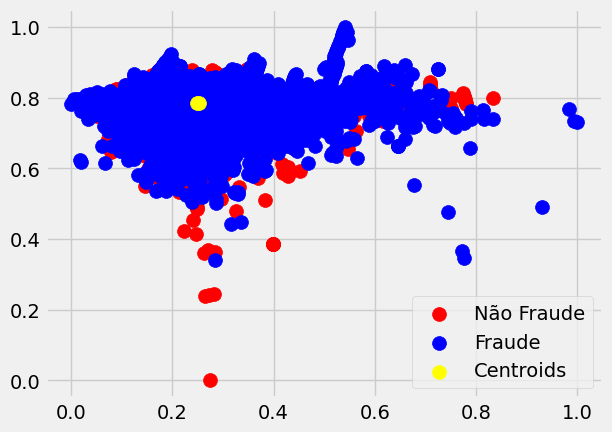

In [113]:
%%time
kmeans_model, kmeans_pred = Kmeans(X)

## Random Forest

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

########## Accuracy Score ##########
Acurácia:  0.999385555282469

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56883
           1       0.72      0.90      0.80        79

    accuracy                           1.00     56962
   macro avg       0.86      0.95      0.90     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56856     8]
 [   27    71]]


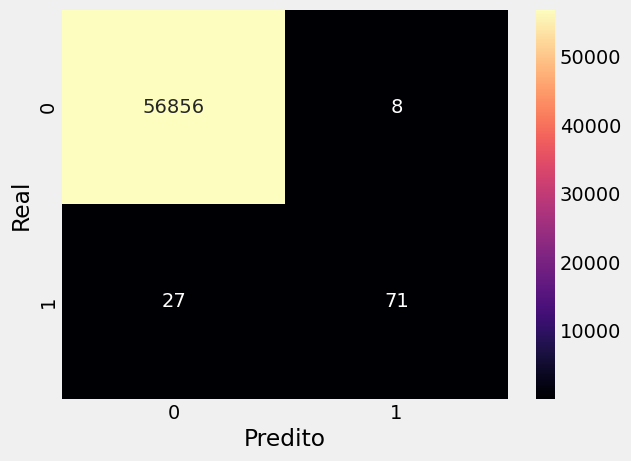

CPU times: user 3.86 s, sys: 50.6 ms, total: 3.91 s
Wall time: 3.85 s


In [114]:
%%time
rf_model, rf_pred = RandomForest(X_train, y_train, X_test, y_test, 5, 10, XAI.NONE)

## Decision Tree Classifier


########## Accuracy Score ##########
Acurácia:  0.9994908886626171

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56877
           1       0.79      0.91      0.84        85

    accuracy                           1.00     56962
   macro avg       0.89      0.95      0.92     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56856     8]
 [   21    77]]


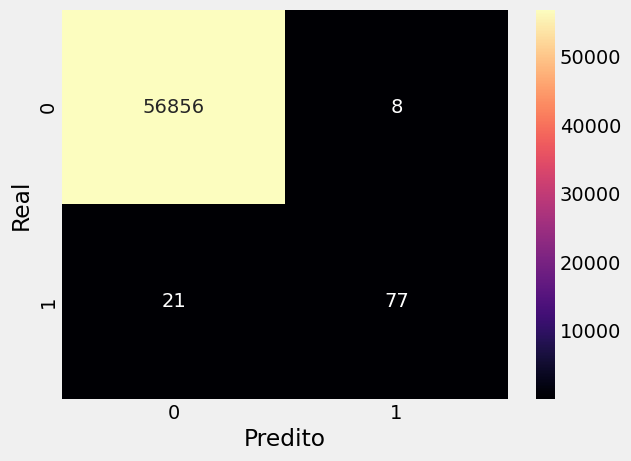

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


CPU times: user 7.01 s, sys: 58.1 ms, total: 7.06 s
Wall time: 4.28 s


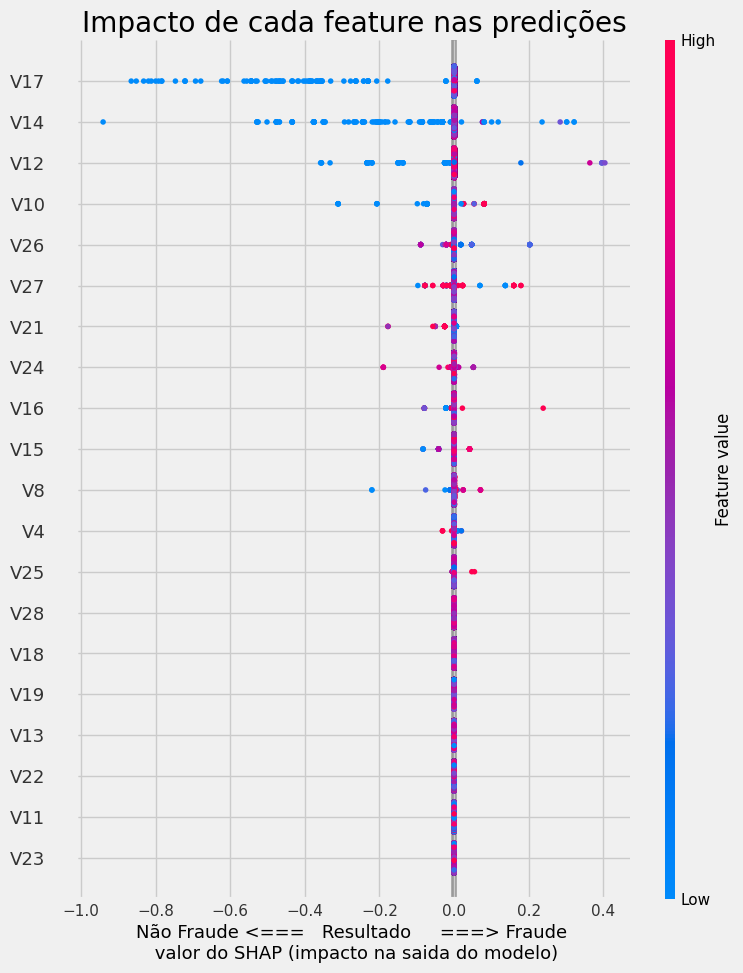

In [115]:
%%time
dt_model, dt_pred = DecisionTree(X_train, y_train, X_test, y_test, XAI.SHAP_Summary)

## KNN


########## Accuracy Score ##########
Acurácia:  0.9990871107053826

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56910
           1       0.50      0.94      0.65        52

    accuracy                           1.00     56962
   macro avg       0.75      0.97      0.83     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56861     3]
 [   49    49]]


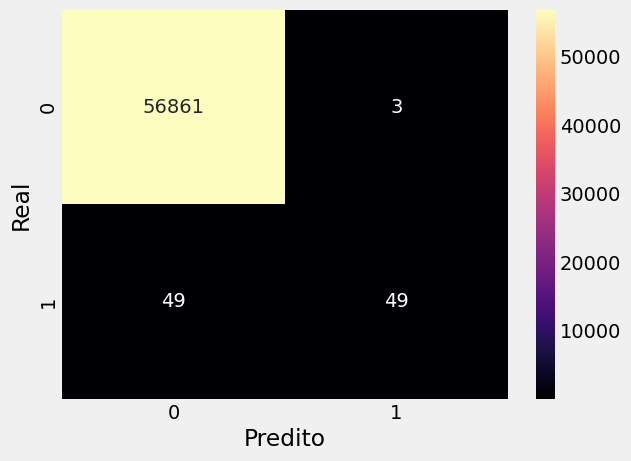

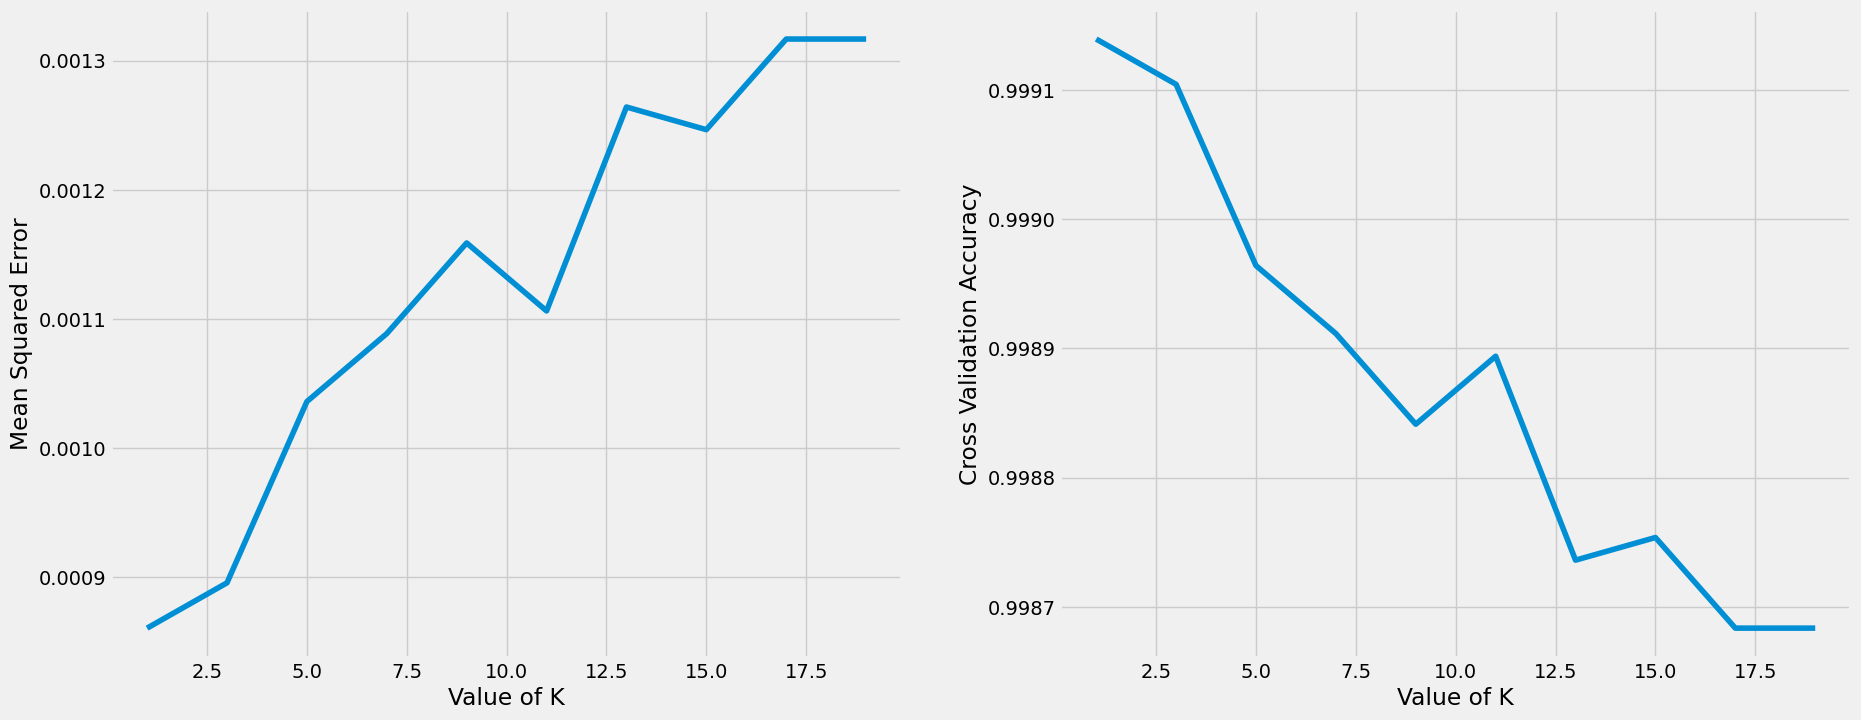

CPU times: user 1min 5s, sys: 1.27 s, total: 1min 6s
Wall time: 38.1 s


In [116]:
%%time
knn_model, knn_pred = KNN(X_train, y_train, X_test, y_test, XAI.NONE)

## Linear Regression

In [117]:
%%time
lr_model, lr_pred = Linear_Regression(X_train, y_train, X_test, y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  0.40763404596871966
CPU times: user 638 ms, sys: 61.7 ms, total: 700 ms
Wall time: 142 ms


## Multivariate Linear Regression

In [118]:
%%time
mlr_model, mlr_pred = Multivariate_Linear_Regression(X_train, y_train, X_test, y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  -2.6623255913317702e+29
CPU times: user 1.25 s, sys: 403 ms, total: 1.66 s
Wall time: 784 ms


## Logistic Regression


########## Accuracy Score ##########
Acurácia:  0.9991573329588147

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56894
           1       0.60      0.87      0.71        68

    accuracy                           1.00     56962
   macro avg       0.80      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56855     9]
 [   39    59]]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


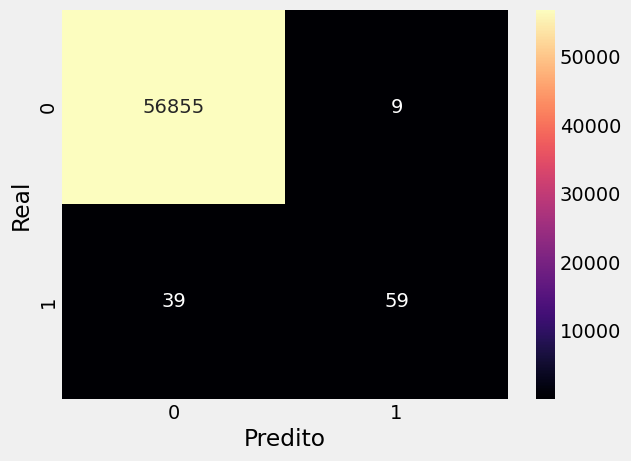

CPU times: user 12.5 s, sys: 1.49 s, total: 14 s
Wall time: 2.1 s


In [119]:
%%time
logR_model, logR_pred = Logistic_Regression(X_train, y_train, X_test, y_test, XAI.NONE)

## Neural Network

Epoch 1/10
7121/7121 [==============================] - 100s 14ms/step - loss: 0.0730 - accuracy: 0.9842 - val_loss: 0.0126 - val_accuracy: 0.9983
Epoch 2/10
7121/7121 [==============================] - 97s 14ms/step - loss: 0.0138 - accuracy: 0.9983 - val_loss: 0.0076 - val_accuracy: 0.9985
Epoch 3/10
7121/7121 [==============================] - 102s 14ms/step - loss: 0.0097 - accuracy: 0.9985 - val_loss: 0.0054 - val_accuracy: 0.9992
Epoch 4/10
7121/7121 [==============================] - 105s 15ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.0065 - val_accuracy: 0.9993
Epoch 5/10
7121/7121 [==============================] - 103s 15ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 0.0078 - val_accuracy: 0.9994
Epoch 6/10
7121/7121 [==============================] - 105s 15ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.0061 - val_accuracy: 0.9993
Epoch 7/10
7121/7121 [==============================] - 103s 15ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.

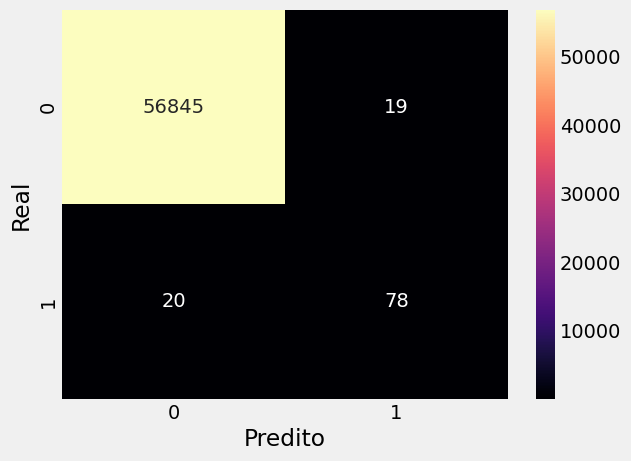

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 184       
                                                                 
 batch_normalization_10 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 layer2 (Dense)              (None, 3)                 27        
                                                                 
 batch_normalization_11 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 3)                

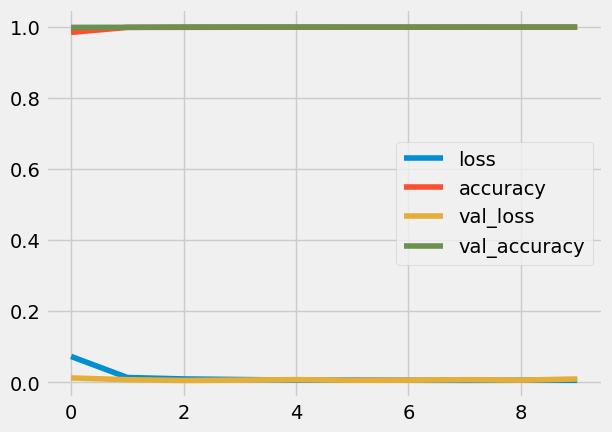

In [120]:
%%time
nn_model, nn_pred = NN(X_train, y_train, X_test, y_test, 10, XAI.NONE)

## Machine Ensemble


########## Random Forest ##########

########## Accuracy Score ##########
Acurácia:  0.999385555282469

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56883
           1       0.72      0.90      0.80        79

    accuracy                           1.00     56962
   macro avg       0.86      0.95      0.90     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56856     8]
 [   27    71]]


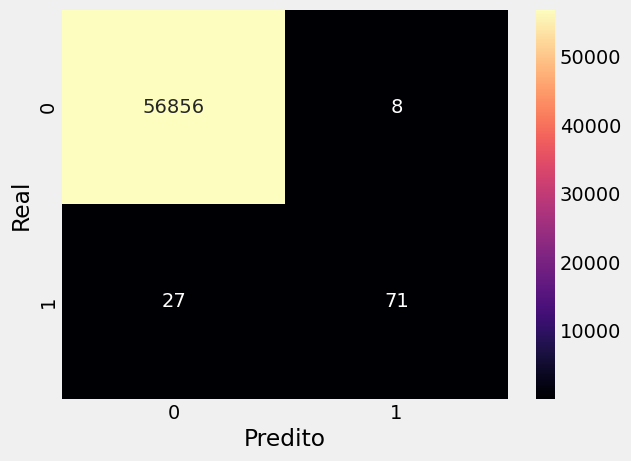


########## Logistic Regression ##########

########## Accuracy Score ##########
Acurácia:  0.9991573329588147

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56894
           1       0.60      0.87      0.71        68

    accuracy                           1.00     56962
   macro avg       0.80      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56855     9]
 [   39    59]]


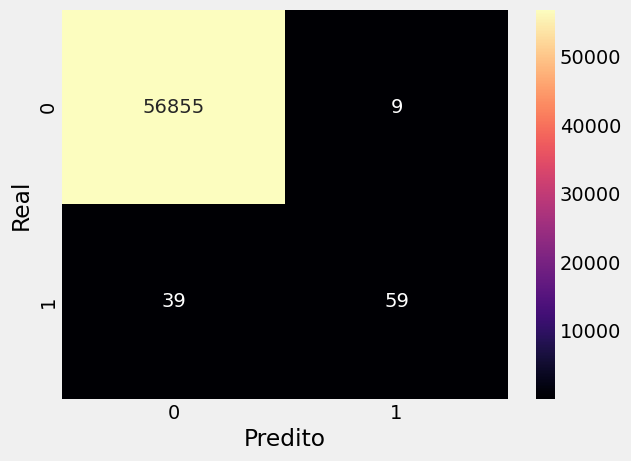


########## KNN ##########

########## Accuracy Score ##########
Acurácia:  0.9990871107053826

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56910
           1       0.50      0.94      0.65        52

    accuracy                           1.00     56962
   macro avg       0.75      0.97      0.83     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56861     3]
 [   49    49]]


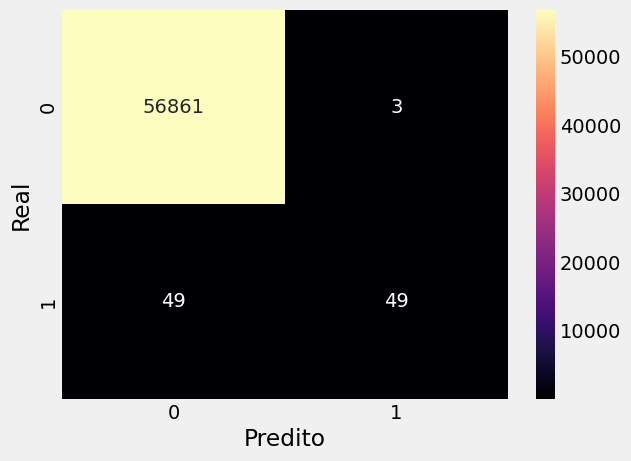

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



########## Ensemble Vote Classifier ##########

########## Accuracy Score ##########
Acurácia:  0.9992099996488887

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56899
           1       0.59      0.92      0.72        63

    accuracy                           1.00     56962
   macro avg       0.80      0.96      0.86     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56859     5]
 [   40    58]]


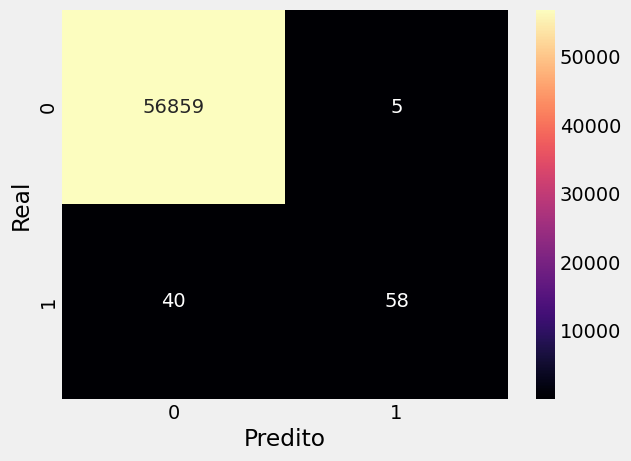

CPU times: user 1min 25s, sys: 2.11 s, total: 1min 27s
Wall time: 18.3 s


In [121]:
%%time
evc_model, evc_pred = EVC(X_train, y_train, X_test, y_test, [rf_model, logR_model, knn_model], [rf_pred, logR_pred, knn_pred], [1, 1, 1], XAI.NONE)

## XGBoost


########## Accuracy Score ##########
Acurácia:  0.9995962220427653

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       0.84      0.92      0.88        89

    accuracy                           1.00     56962
   macro avg       0.92      0.96      0.94     56962
weighted avg       1.00      1.00      1.00     56962


########## Confusion Matrix ##########
[[56857     7]
 [   16    82]]


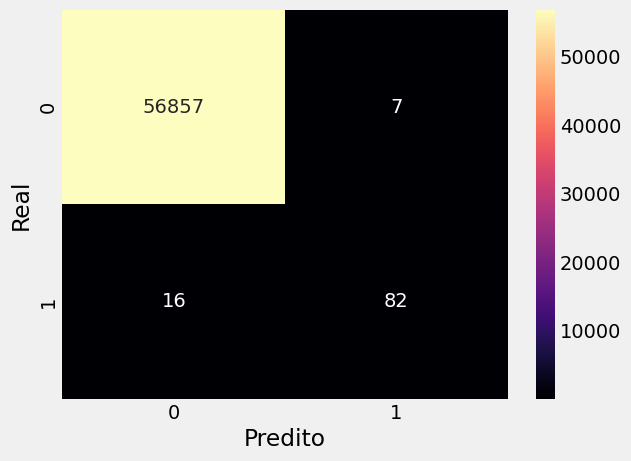

CPU times: user 5.78 s, sys: 1.59 s, total: 7.36 s
Wall time: 1.33 s


In [122]:
%%time
xgb_model, xgb_pred = XGB(X_train, y_train, X_test, y_test, XAI.NONE)

## SVM (SVC)

In [123]:
%%time
svc_model, svc_pred = SVC_method(X_train, y_train, X_test, y_test, XAI.NONE)

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



########## Rˆ2 Score ##########
Rˆ2 Score:  0.9992451107756047
CPU times: user 40.9 s, sys: 193 ms, total: 41.1 s
Wall time: 41.7 s


Liblinear failed to converge, increase the number of iterations.


# Balanceamento do Dataset

## Undersampling (Subsampling)



In [124]:
sub_data = Subsampling(data)
# Splitting Features and Target
sub_X = sub_data.drop('Class', axis=1)
sub_y = sub_data['Class']
sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(sub_X, sub_y, test_size=0.2, random_state=42)



Contagem de classes antes do balanceamento:
Class
0    284315
1       492
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Class
0    492
1    492
Name: count, dtype: int64


## Undersampling (Random Under Sampler - RUS)

In [125]:
X_rus, y_rus = RUS(X, y)
rus_X_train, rus_X_test, rus_y_train, rus_y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)

Contagem de classes antes do balanceamento:
Class
0    284315
1       492
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Class
0    4920
1     492
Name: count, dtype: int64


## Oversampling (SMOTE)

In [126]:
X_smote, y_smote = Smote(X, y)
smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Contagem de classes antes do balanceamento:
Class
0    284315
1       492
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Class
0    284315
1    284315
Name: count, dtype: int64


## Oversampling (ADASYN)

In [127]:
X_over_ada, y_over_ada = Adasyn(X, y)
ada_X_train, ada_X_test, ada_y_train, ada_y_test = train_test_split(X_over_ada, y_over_ada, test_size=0.2, random_state=42)

Contagem de classes antes do balanceamento:
Class
0    284315
1       492
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Class
0    284315
1    284232
Name: count, dtype: int64


## Undersampling e Oversampling (RUS-ADASYN)

In [128]:
X_rusada, y_rusada = Adasyn(X_rus, y_rus)
rusada_X_train, rusada_X_test, rusada_y_train, rusada_y_test = train_test_split(X_rusada, y_rusada, test_size=0.2, random_state=42)

Contagem de classes antes do balanceamento:
Class
0    4920
1     492
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Class
0    4920
1    4874
Name: count, dtype: int64


# Executando técnicas com Dataset balanceado

## Undersampling (Subsampling)

### Linear Regression

In [129]:
%%time
lr_sub_model, lr_sub_pred = Linear_Regression(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  0.568963846485355
CPU times: user 85 ms, sys: 33.2 ms, total: 118 ms
Wall time: 38.4 ms


### Multivariate Linear Regression

In [130]:
%%time
mlr_sub_model, mlr_sub_pred = Multivariate_Linear_Regression(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  -4.6541971467820125e+26
CPU times: user 77.7 ms, sys: 22.7 ms, total: 100 ms
Wall time: 16.4 ms


### Logistic Regression


########## Accuracy Score ##########
Acurácia:  0.9390862944162437

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        93
           1       0.92      0.97      0.94       104

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197


########## Confusion Matrix ##########
[[ 84   3]
 [  9 101]]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


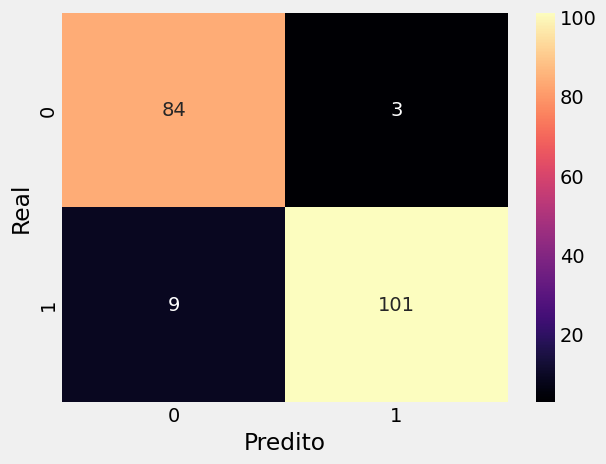

CPU times: user 1.32 s, sys: 180 ms, total: 1.5 s
Wall time: 253 ms


In [131]:
%%time
logR_sub_model, logR_sub_pred = Logistic_Regression(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)

### Kmeans

CPU times: user 723 ms, sys: 181 ms, total: 904 ms
Wall time: 139 ms


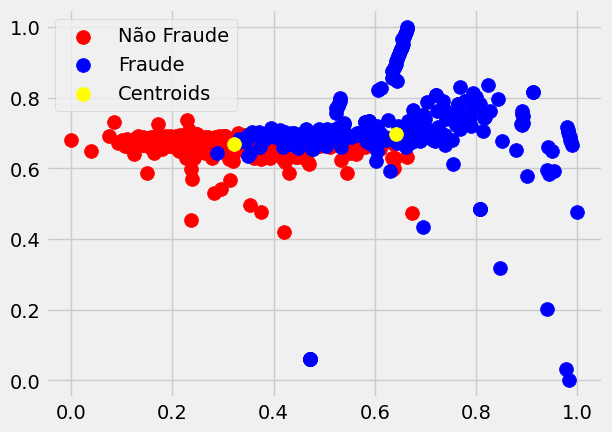

In [132]:
%%time
kmeans_sub_model, kmeans_sub_pred = Kmeans(sub_X)

### Random Forest

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


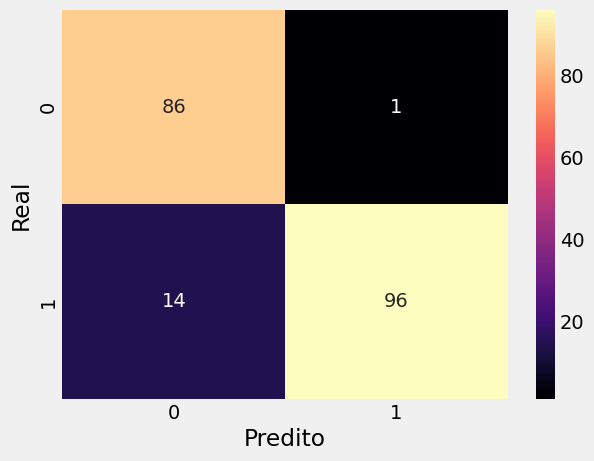

CPU times: user 792 ms, sys: 90.5 ms, total: 882 ms
Wall time: 403 ms


In [133]:
%%time
rf_sub_model, rf_sub_pred = RandomForest(sub_X_train, sub_y_train, sub_X_test, sub_y_test, 500, 200, XAI.NONE)

### Decision Tree


########## Accuracy Score ##########
Acurácia:  0.9137055837563451

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        98
           1       0.87      0.97      0.92        99

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197


########## Confusion Matrix ##########
[[84  3]
 [14 96]]


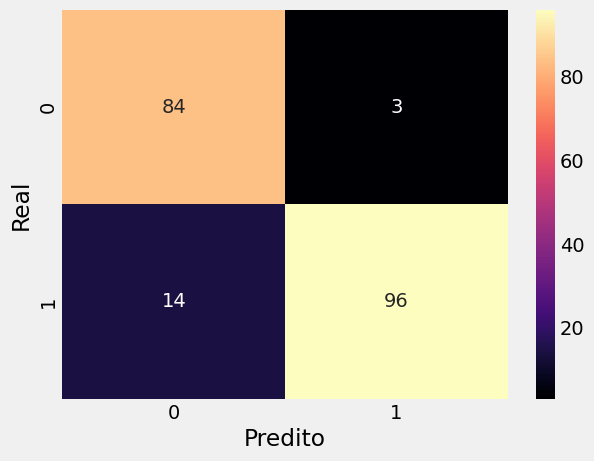

CPU times: user 226 ms, sys: 5.86 ms, total: 232 ms
Wall time: 78.4 ms


In [134]:
%%time
dt_sub_model, dt_sub_pred = DecisionTree(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)

### KNN


########## Accuracy Score ##########
Acurácia:  0.8781725888324873

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       101
           1       0.83      0.95      0.88        96

    accuracy                           0.88       197
   macro avg       0.88      0.88      0.88       197
weighted avg       0.89      0.88      0.88       197


########## Confusion Matrix ##########
[[82  5]
 [19 91]]


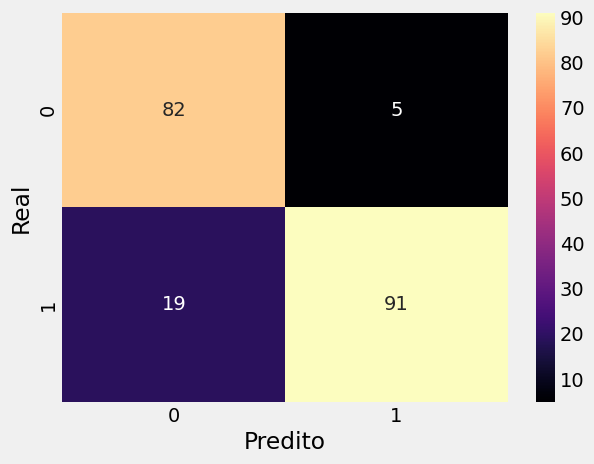

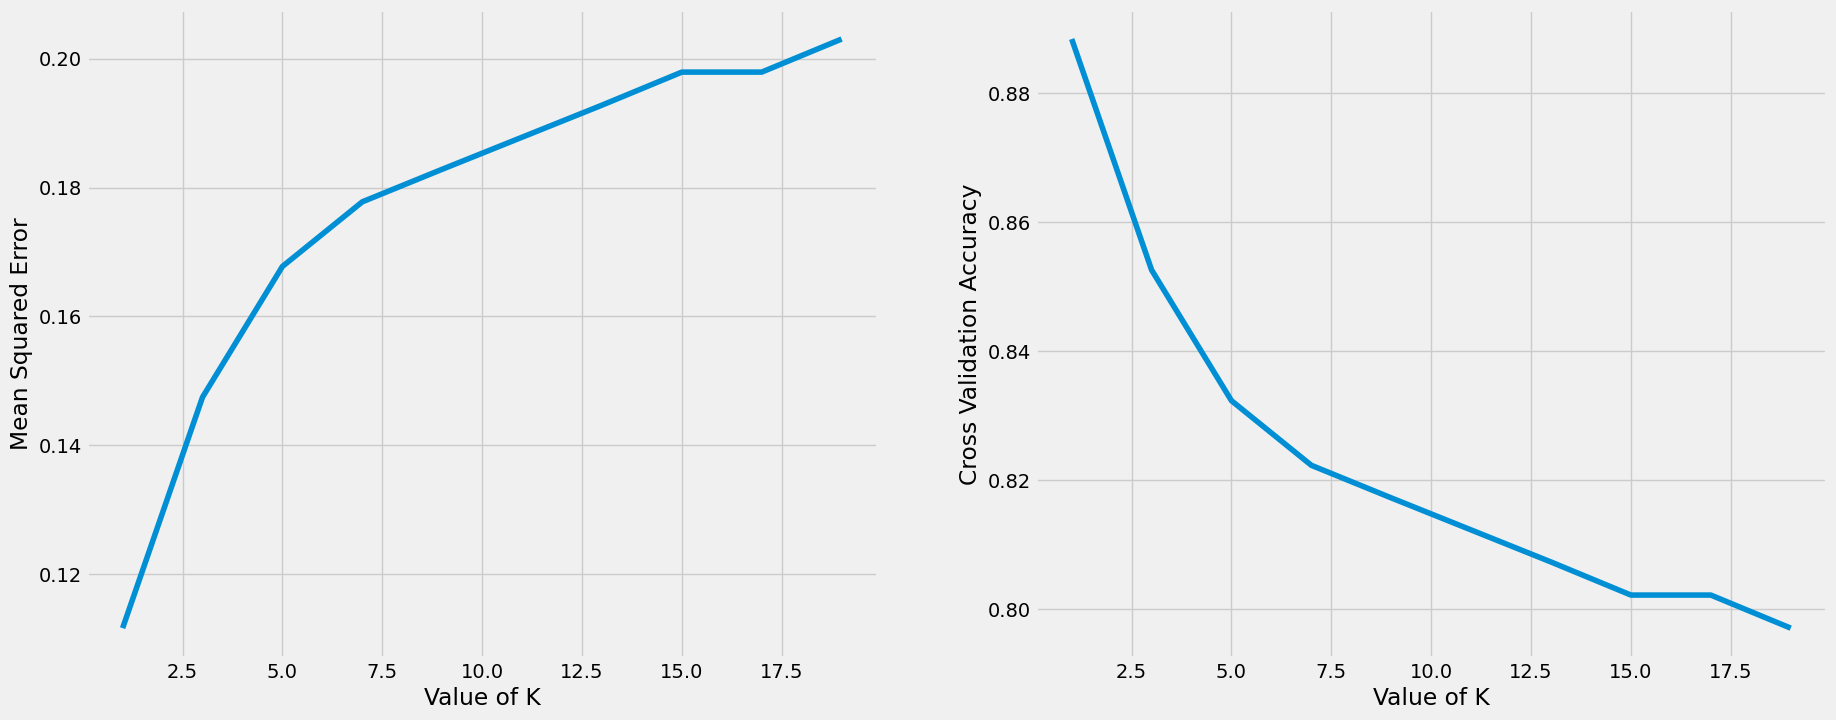

CPU times: user 2.17 s, sys: 1.01 s, total: 3.18 s
Wall time: 5.31 s


In [135]:
%%time
knn_sub_model, knn_sub_pred = KNN(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)

### Neural Network

Epoch 1/50
25/25 [==============================] - 2s 45ms/step - loss: 0.9431 - accuracy: 0.5451 - val_loss: 0.7444 - val_accuracy: 0.7005
Epoch 2/50
25/25 [==============================] - 0s 18ms/step - loss: 1.0315 - accuracy: 0.5184 - val_loss: 0.6375 - val_accuracy: 0.7868
Epoch 3/50
25/25 [==============================] - 0s 16ms/step - loss: 0.9773 - accuracy: 0.5476 - val_loss: 0.5959 - val_accuracy: 0.8934
Epoch 4/50
25/25 [==============================] - 0s 16ms/step - loss: 0.7837 - accuracy: 0.6048 - val_loss: 0.5932 - val_accuracy: 0.8883
Epoch 5/50
25/25 [==============================] - 0s 15ms/step - loss: 0.8920 - accuracy: 0.6213 - val_loss: 0.5913 - val_accuracy: 0.8629
Epoch 6/50
25/25 [==============================] - 0s 15ms/step - loss: 0.8640 - accuracy: 0.6112 - val_loss: 0.5851 - val_accuracy: 0.8629
Epoch 7/50
25/25 [==============================] - 0s 16ms/step - loss: 0.7285 - accuracy: 0.6531 - val_loss: 0.5742 - val_accuracy: 0.8731
Epoch 8/50
25

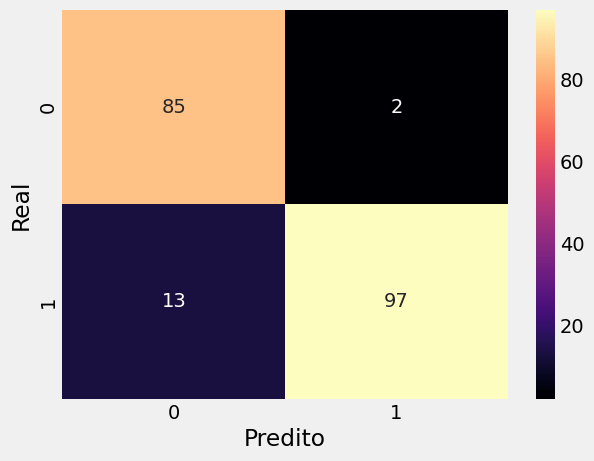

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 184       
                                                                 
 batch_normalization_12 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 8)                 0         
                                                                 
 layer2 (Dense)              (None, 3)                 27        
                                                                 
 batch_normalization_13 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 3)                

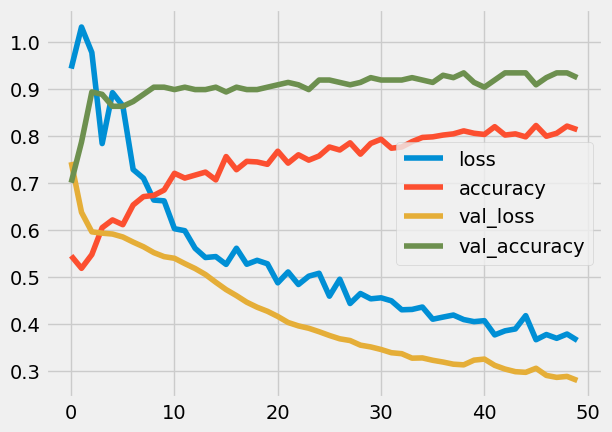

In [136]:
%%time
nn_sub_model, nn_sub_pred = NN(sub_X_train, sub_y_train, sub_X_test, sub_y_test, 50, XAI.NONE)

### Machine Ensemble


########## Random Forest ##########

########## Accuracy Score ##########
Acurácia:  0.9238578680203046

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       100
           1       0.87      0.99      0.93        97

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197


########## Confusion Matrix ##########
[[86  1]
 [14 96]]


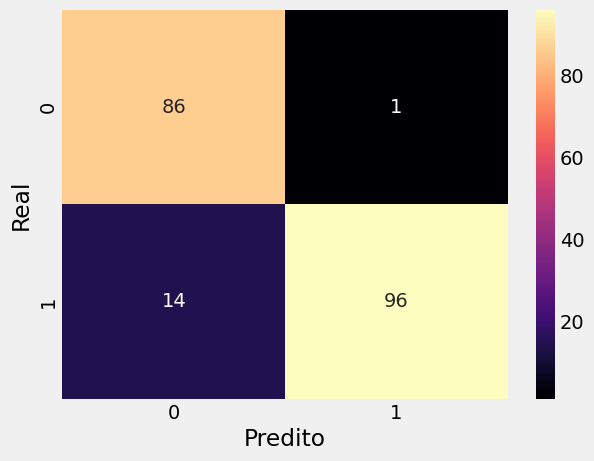


########## Logistic Regression ##########

########## Accuracy Score ##########
Acurácia:  0.9390862944162437

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        93
           1       0.92      0.97      0.94       104

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197


########## Confusion Matrix ##########
[[ 84   3]
 [  9 101]]


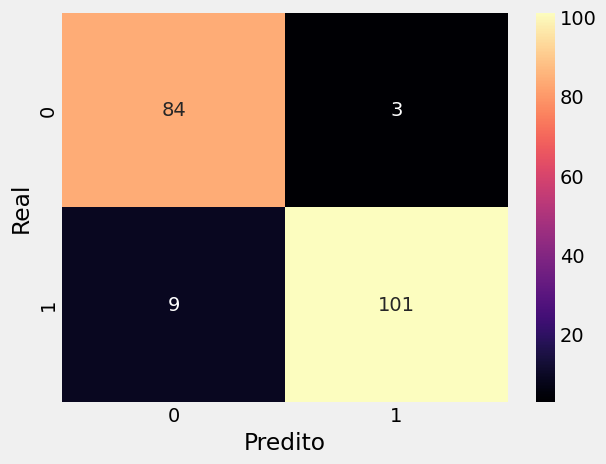


########## KNN ##########

########## Accuracy Score ##########
Acurácia:  0.8781725888324873

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       101
           1       0.83      0.95      0.88        96

    accuracy                           0.88       197
   macro avg       0.88      0.88      0.88       197
weighted avg       0.89      0.88      0.88       197


########## Confusion Matrix ##########
[[82  5]
 [19 91]]


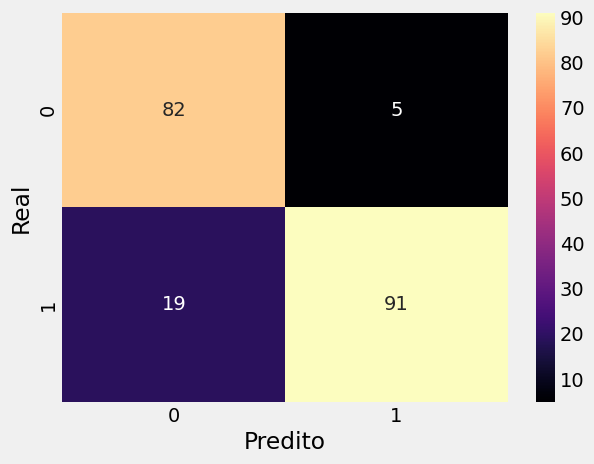

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


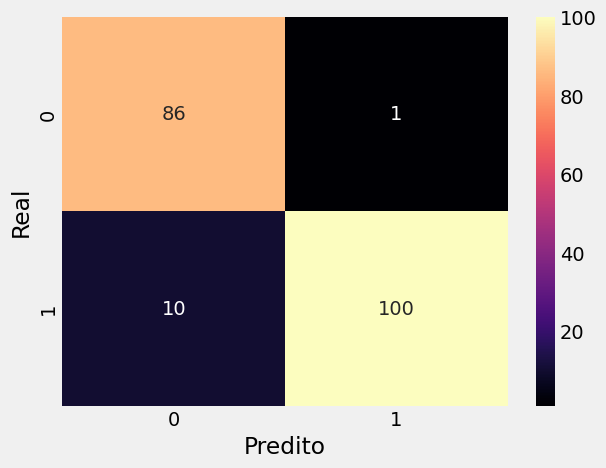

CPU times: user 2.47 s, sys: 455 ms, total: 2.93 s
Wall time: 840 ms


In [137]:
%%time
evc_sub_model, evc_sub_pred = EVC(sub_X_train, sub_y_train, sub_X_test, sub_y_test, [rf_sub_model, logR_sub_model, knn_sub_model], [rf_sub_pred, logR_sub_pred, knn_sub_pred], [1, 1, 1], XAI.NONE)

### XGBoost


########## Accuracy Score ##########
Acurácia:  0.949238578680203

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        97
           1       0.91      1.00      0.95       100

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197


########## Confusion Matrix ##########
[[ 87   0]
 [ 10 100]]


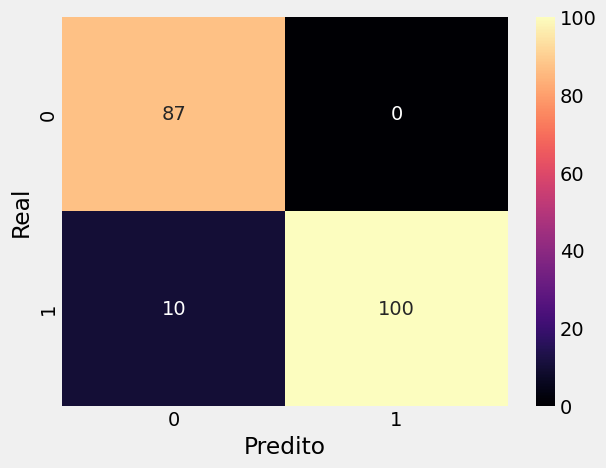

CPU times: user 956 ms, sys: 427 ms, total: 1.38 s
Wall time: 207 ms


In [138]:
%%time
xgb_sub_model, xgb_sub_pred = XGB(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)

### SVC (SVM)

In [139]:
%%time
svc_sub_model, svc_sub_pred = SVC_method(sub_X_train, sub_y_train, sub_X_test, sub_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  0.9289340101522843
CPU times: user 121 ms, sys: 50.6 ms, total: 171 ms
Wall time: 27.5 ms


The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
Liblinear failed to converge, increase the number of iterations.


## Oversampling (SMOTE)

### Linear Regression

In [140]:
%%time
lr_smote_model, lr_smote_pred = Linear_Regression(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  0.6496762955725313
CPU times: user 1.29 s, sys: 392 ms, total: 1.68 s
Wall time: 313 ms


### Multivariate Linear Regression

In [141]:
%%time
mlr_smote_model, mlr_smote_pred = Multivariate_Linear_Regression(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  -6.851239193023712e+26
CPU times: user 3.71 s, sys: 308 ms, total: 4.02 s
Wall time: 3.14 s


### Logistic Regression

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



########## Accuracy Score ##########
Acurácia:  0.9578196718428503

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     59407
           1       0.93      0.98      0.96     54319

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726


########## Confusion Matrix ##########
[[55680  1070]
 [ 3727 53249]]


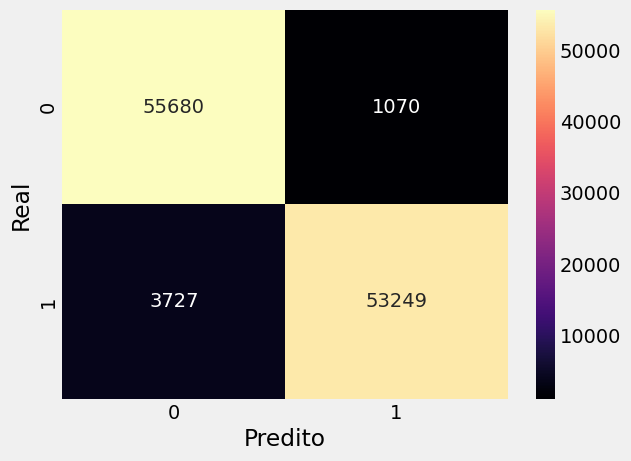

CPU times: user 23.1 s, sys: 2.54 s, total: 25.6 s
Wall time: 4.28 s


In [142]:
%%time
logR_smote_model, logR_smote_pred = Logistic_Regression(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)

### Kmeans

CPU times: user 10.5 s, sys: 2.47 s, total: 13 s
Wall time: 2.29 s


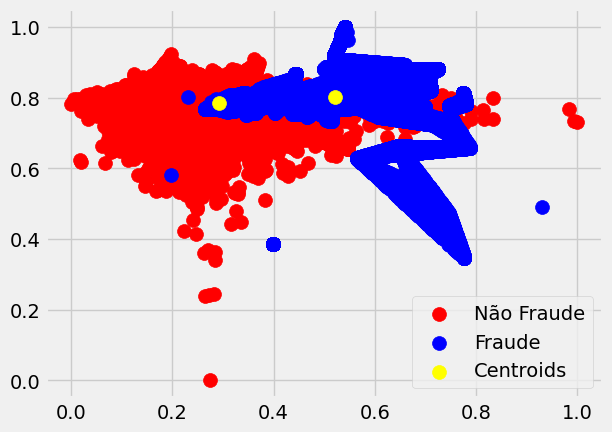

In [143]:
%%time
kmeans_smote_model, kmeans_smote_pred = Kmeans(X_smote)

### Random Forest

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

########## Accuracy Score ##########
Acurácia:  0.9560258867805075

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     61039
           1       0.92      0.99      0.95     52687

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726


########## Confusion Matrix ##########
[[56394   356]
 [ 4645 52331]]


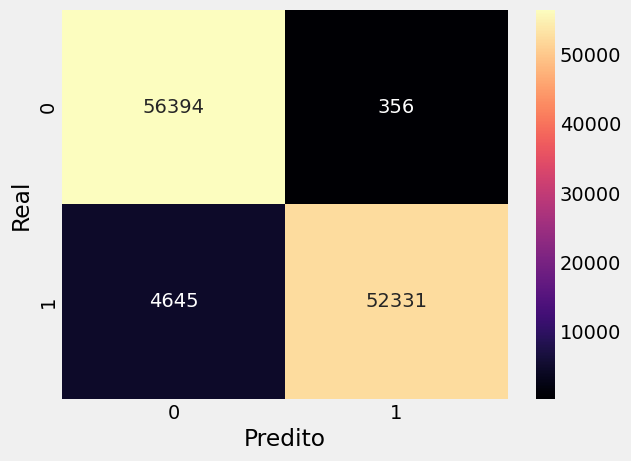

CPU times: user 8.01 s, sys: 121 ms, total: 8.13 s
Wall time: 8.26 s


In [144]:
%%time
rf_smote_model, rf_smote_pred = RandomForest(smote_X_train, smote_y_train, smote_X_test, smote_y_test, 5, 10, XAI.NONE)

### Decision Tree


########## Accuracy Score ##########
Acurácia:  0.964361711481983

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57941
           1       0.95      0.97      0.96     55785

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726


########## Confusion Matrix ##########
[[55319  1431]
 [ 2622 54354]]


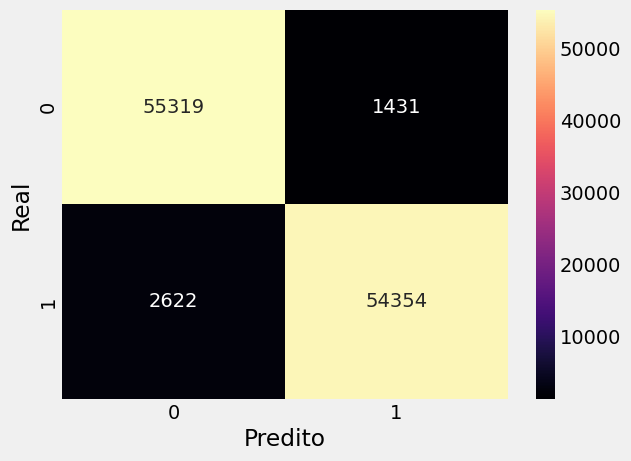

CPU times: user 6.6 s, sys: 96.4 ms, total: 6.69 s
Wall time: 6.42 s


In [145]:
%%time
dt_smote_model, dt_smote_pred = DecisionTree(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)

### KNN


########## Accuracy Score ##########
Acurácia:  0.9958408807132934

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56343
           1       1.00      0.99      1.00     57383

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


########## Confusion Matrix ##########
[[56310   440]
 [   33 56943]]


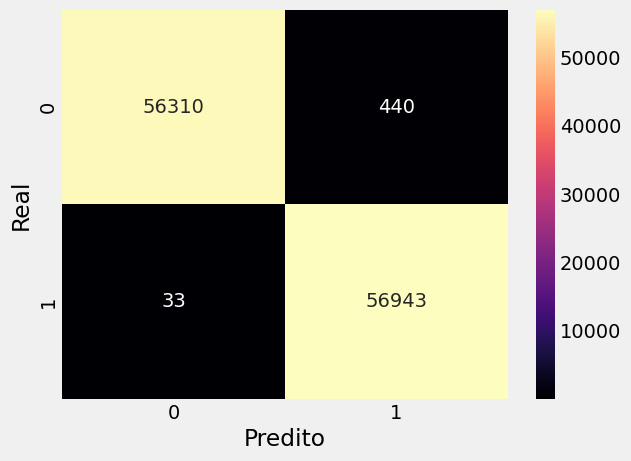

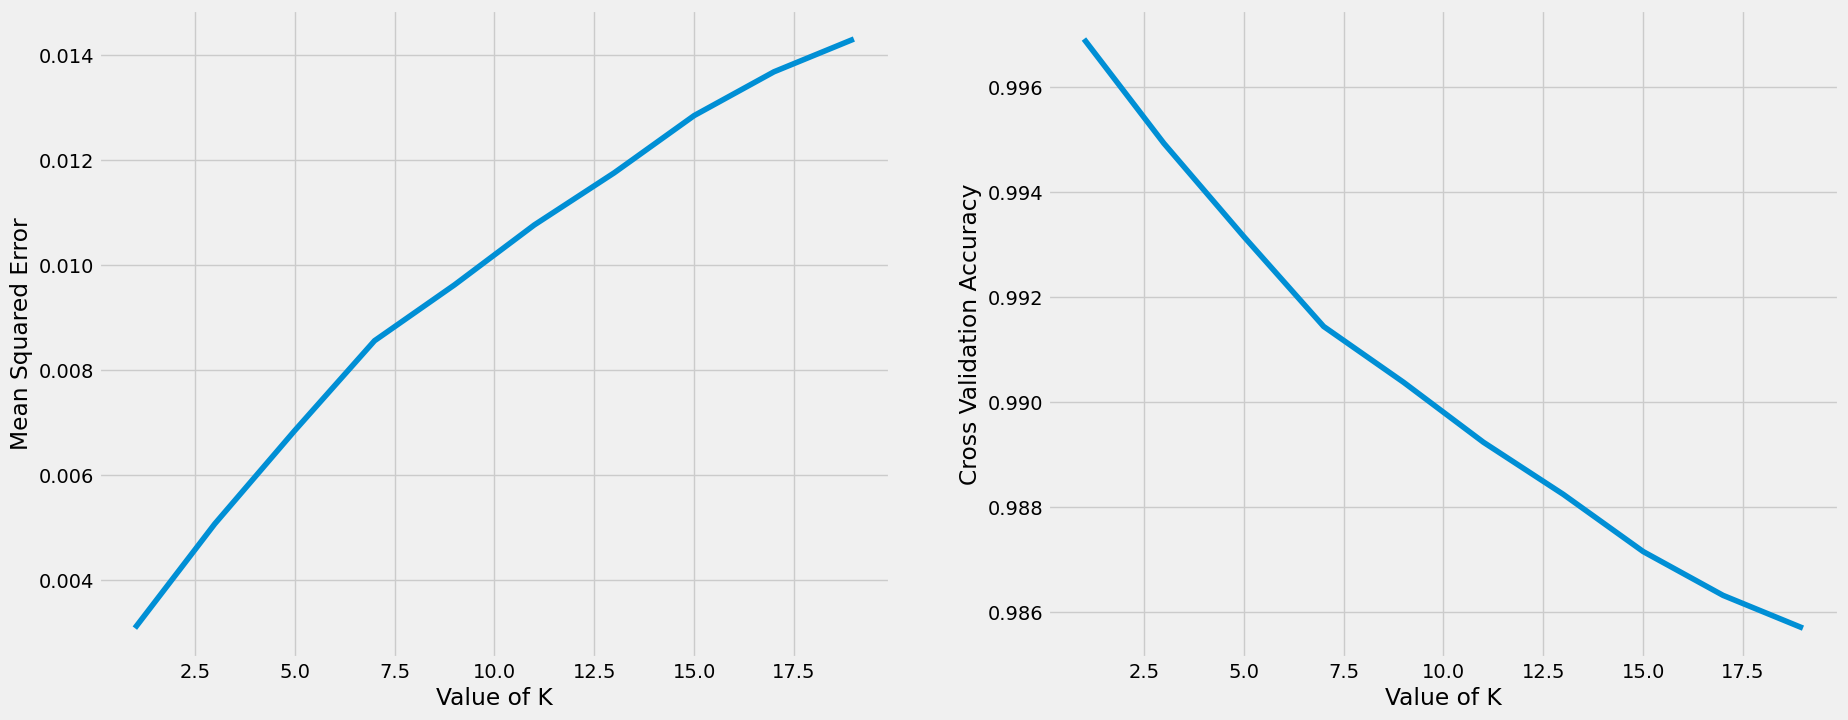

CPU times: user 4min 52s, sys: 3.69 s, total: 4min 56s
Wall time: 2min 40s


In [146]:
%%time
knn_smote_model, knn_smote_pred = KNN(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)

### Neural Network

Epoch 1/10
14216/14216 [==============================] - 209s 15ms/step - loss: 0.2297 - accuracy: 0.9117 - val_loss: 0.1301 - val_accuracy: 0.9511
Epoch 2/10
14216/14216 [==============================] - 208s 15ms/step - loss: 0.1985 - accuracy: 0.9249 - val_loss: 0.1275 - val_accuracy: 0.9505
Epoch 3/10
14216/14216 [==============================] - 201s 14ms/step - loss: 0.1969 - accuracy: 0.9252 - val_loss: 0.1261 - val_accuracy: 0.9503
Epoch 4/10
14216/14216 [==============================] - 206s 14ms/step - loss: 0.1953 - accuracy: 0.9253 - val_loss: 0.1255 - val_accuracy: 0.9515
Epoch 5/10
14216/14216 [==============================] - 205s 14ms/step - loss: 0.1957 - accuracy: 0.9252 - val_loss: 0.1282 - val_accuracy: 0.9523
Epoch 6/10
14216/14216 [==============================] - 210s 15ms/step - loss: 0.1952 - accuracy: 0.9253 - val_loss: 0.1270 - val_accuracy: 0.9527
Epoch 7/10
14216/14216 [==============================] - 204s 14ms/step - loss: 0.1951 - accuracy: 0.9256

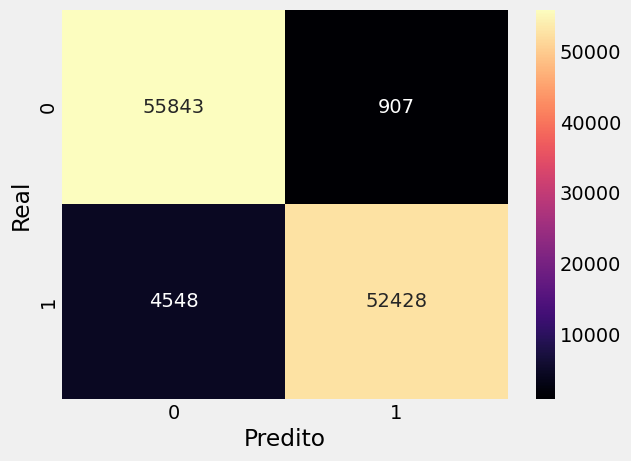

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 184       
                                                                 
 batch_normalization_14 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 layer2 (Dense)              (None, 3)                 27        
                                                                 
 batch_normalization_15 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 3)                

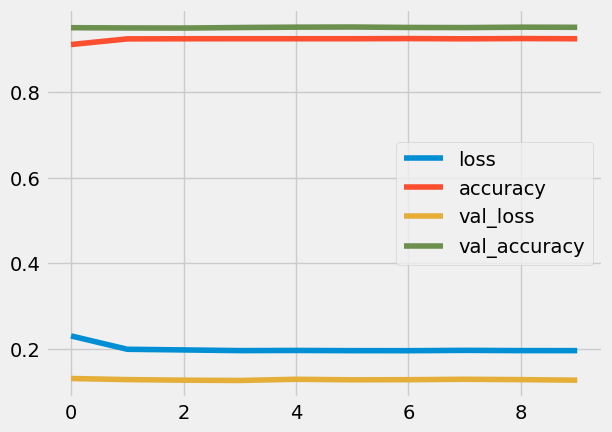

In [147]:
%%time
nn_smote_model, nn_smote_pred = NN(smote_X_train, smote_y_train, smote_X_test, smote_y_test, 10, XAI.NONE)

### Machine Ensemble


########## Random Forest ##########

########## Accuracy Score ##########
Acurácia:  0.9560258867805075

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     61039
           1       0.92      0.99      0.95     52687

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726


########## Confusion Matrix ##########
[[56394   356]
 [ 4645 52331]]


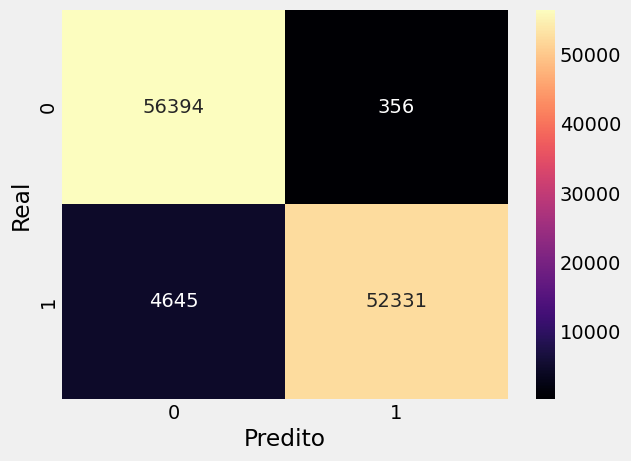


########## Logistic Regression ##########

########## Accuracy Score ##########
Acurácia:  0.9578196718428503

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     59407
           1       0.93      0.98      0.96     54319

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726


########## Confusion Matrix ##########
[[55680  1070]
 [ 3727 53249]]


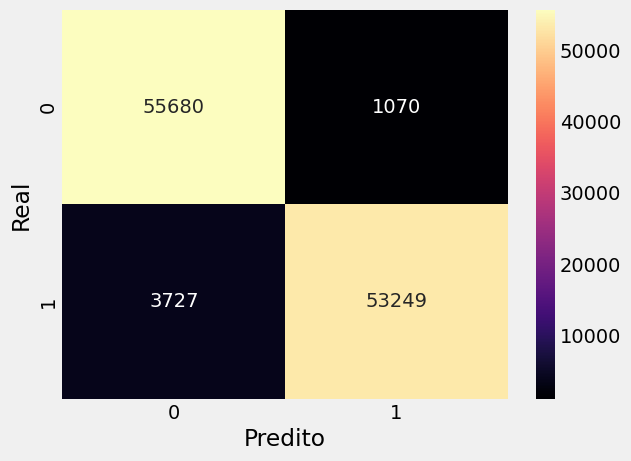


########## KNN ##########

########## Accuracy Score ##########
Acurácia:  0.9958408807132934

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56343
           1       1.00      0.99      1.00     57383

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


########## Confusion Matrix ##########
[[56310   440]
 [   33 56943]]


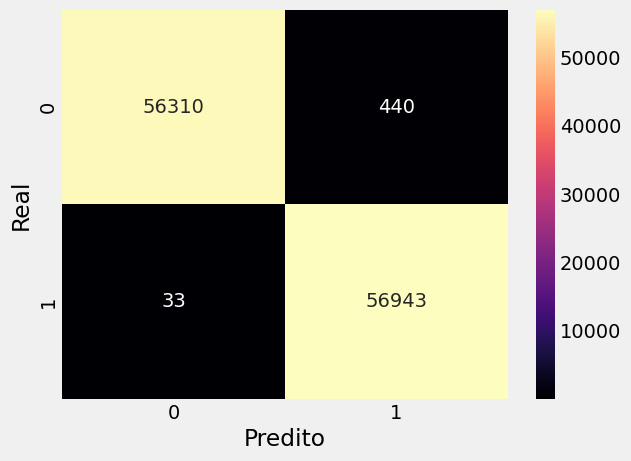

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



########## Ensemble Vote Classifier ##########

########## Accuracy Score ##########
Acurácia:  0.9800221585213583

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58608
           1       0.96      1.00      0.98     55118

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726


########## Confusion Matrix ##########
[[56543   207]
 [ 2065 54911]]


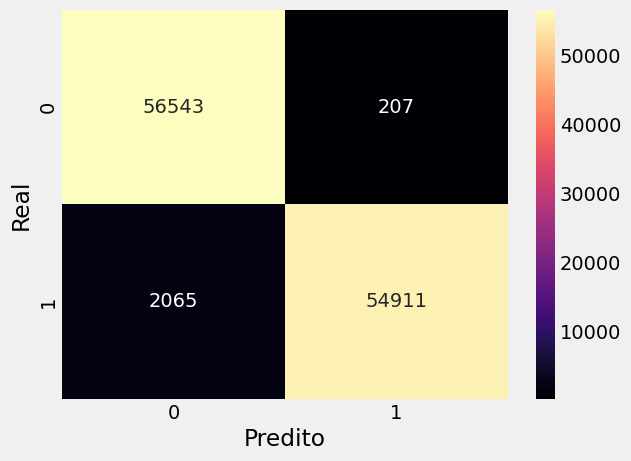

CPU times: user 5min 10s, sys: 5.16 s, total: 5min 15s
Wall time: 58.7 s


In [148]:
%%time
evc_smote_model, evc_smote_pred = EVC(smote_X_train, smote_y_train, smote_X_test, smote_y_test, [rf_smote_model, logR_smote_model, knn_smote_model], [rf_smote_pred, logR_smote_pred, knn_smote_pred], [1, 1, 1], XAI.NONE)

### XGBoost


########## Accuracy Score ##########
Acurácia:  0.9997625872711605

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56723
           1       1.00      1.00      1.00     57003

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


########## Confusion Matrix ##########
[[56723    27]
 [    0 56976]]


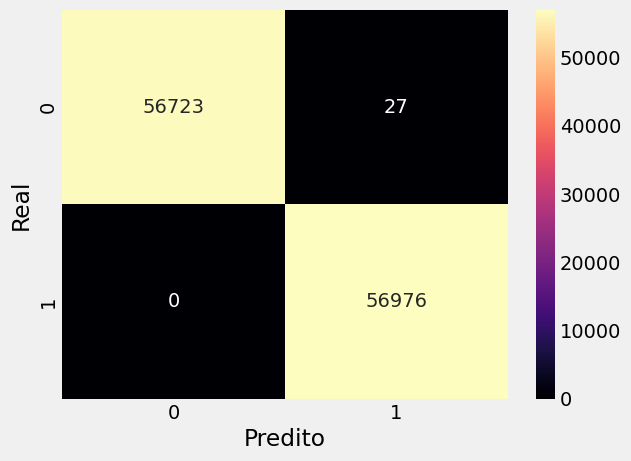

CPU times: user 10.8 s, sys: 2.62 s, total: 13.4 s
Wall time: 2.43 s


In [149]:
%%time
xgb_smote_model, xgb_smote_pred = XGB(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)

### SVC (SVM)

In [150]:
%%time
svc_smote_model, svc_smote_pred = SVC_method(smote_X_train, smote_y_train, smote_X_test, smote_y_test, XAI.NONE)

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



########## Rˆ2 Score ##########
Rˆ2 Score:  0.9265339500202241
CPU times: user 1min 39s, sys: 795 ms, total: 1min 40s
Wall time: 1min 43s


Liblinear failed to converge, increase the number of iterations.


## Oversampling (ADASYN)

### Linear Regression

In [151]:
%%time
lr_ada_model, lr_ada_pred = Linear_Regression(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  0.5722789396172461
CPU times: user 2.28 s, sys: 369 ms, total: 2.65 s
Wall time: 658 ms


### Multivariate Linear Regression

In [152]:
%%time
mlr_ada_model, mlr_ada_pred = Multivariate_Linear_Regression(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  -6.196704000428971e+27
CPU times: user 6.92 s, sys: 236 ms, total: 7.16 s
Wall time: 6 s


### Logistic Regression

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



########## Accuracy Score ##########
Acurácia:  0.9145633629408143

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     59801
           1       0.89      0.94      0.91     53909

    accuracy                           0.91    113710
   macro avg       0.91      0.92      0.91    113710
weighted avg       0.92      0.91      0.91    113710


########## Confusion Matrix ##########
[[53433  3347]
 [ 6368 50562]]


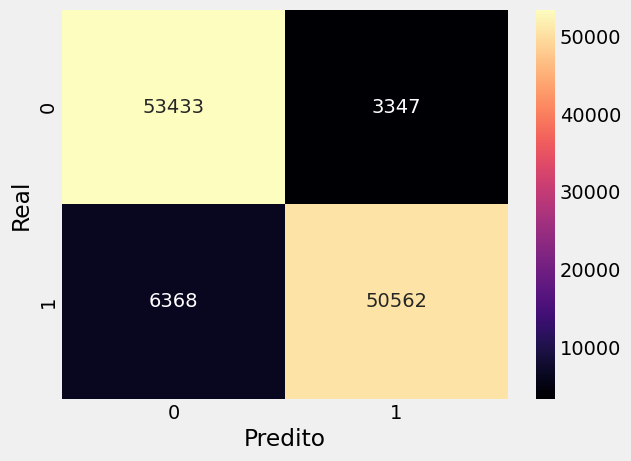

CPU times: user 21 s, sys: 3.03 s, total: 24 s
Wall time: 4.34 s


In [153]:
%%time
logR_ada_model, logR_ada_pred = Logistic_Regression(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)

### Kmeans

CPU times: user 11.6 s, sys: 4.12 s, total: 15.7 s
Wall time: 2.94 s


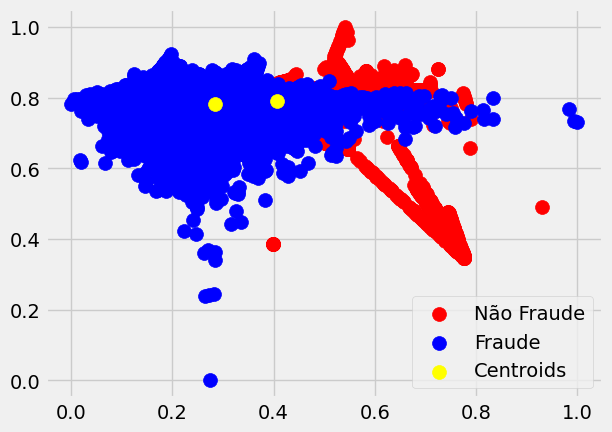

In [154]:
%%time
kmeans_ada_model, kmeans_ada_pred = Kmeans(X_over_ada)

### Random Forest

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

########## Accuracy Score ##########
Acurácia:  0.9324245888664145

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     60158
           1       0.90      0.96      0.93     53552

    accuracy                           0.93    113710
   macro avg       0.93      0.93      0.93    113710
weighted avg       0.93      0.93      0.93    113710


########## Confusion Matrix ##########
[[54627  2153]
 [ 5531 51399]]


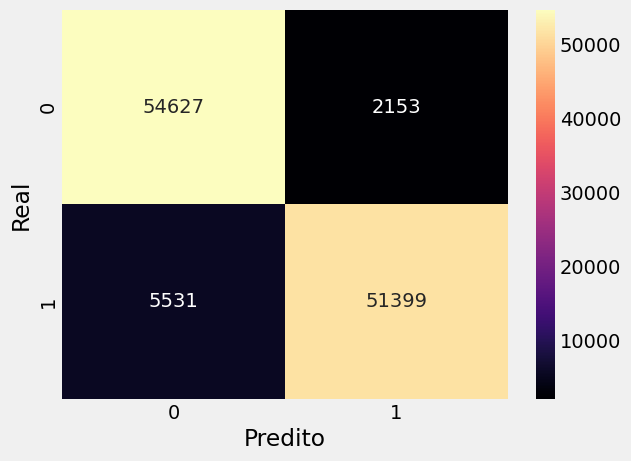

CPU times: user 7.79 s, sys: 128 ms, total: 7.92 s
Wall time: 8.05 s


In [155]:
%%time
rf_ada_model, rf_ada_pred = RandomForest(ada_X_train, ada_y_train, ada_X_test, ada_y_test, 5, 10, XAI.NONE)

### Decision Tree


########## Accuracy Score ##########
Acurácia:  0.9326532407000264

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     57426
           1       0.93      0.94      0.93     56284

    accuracy                           0.93    113710
   macro avg       0.93      0.93      0.93    113710
weighted avg       0.93      0.93      0.93    113710


########## Confusion Matrix ##########
[[53274  3506]
 [ 4152 52778]]


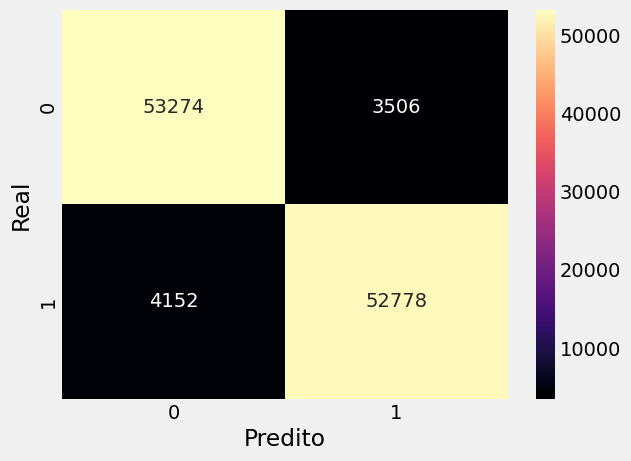

CPU times: user 6.6 s, sys: 126 ms, total: 6.73 s
Wall time: 6.6 s


In [156]:
%%time
dt_ada_model, dt_ada_pred = DecisionTree(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)

### KNN


########## Accuracy Score ##########
Acurácia:  0.9950048368657111

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56216
           1       1.00      0.99      1.00     57494

    accuracy                           1.00    113710
   macro avg       0.99      1.00      1.00    113710
weighted avg       1.00      1.00      1.00    113710


########## Confusion Matrix ##########
[[56214   566]
 [    2 56928]]


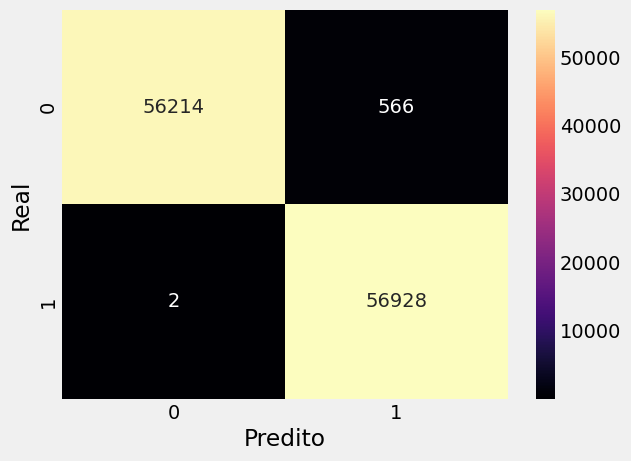

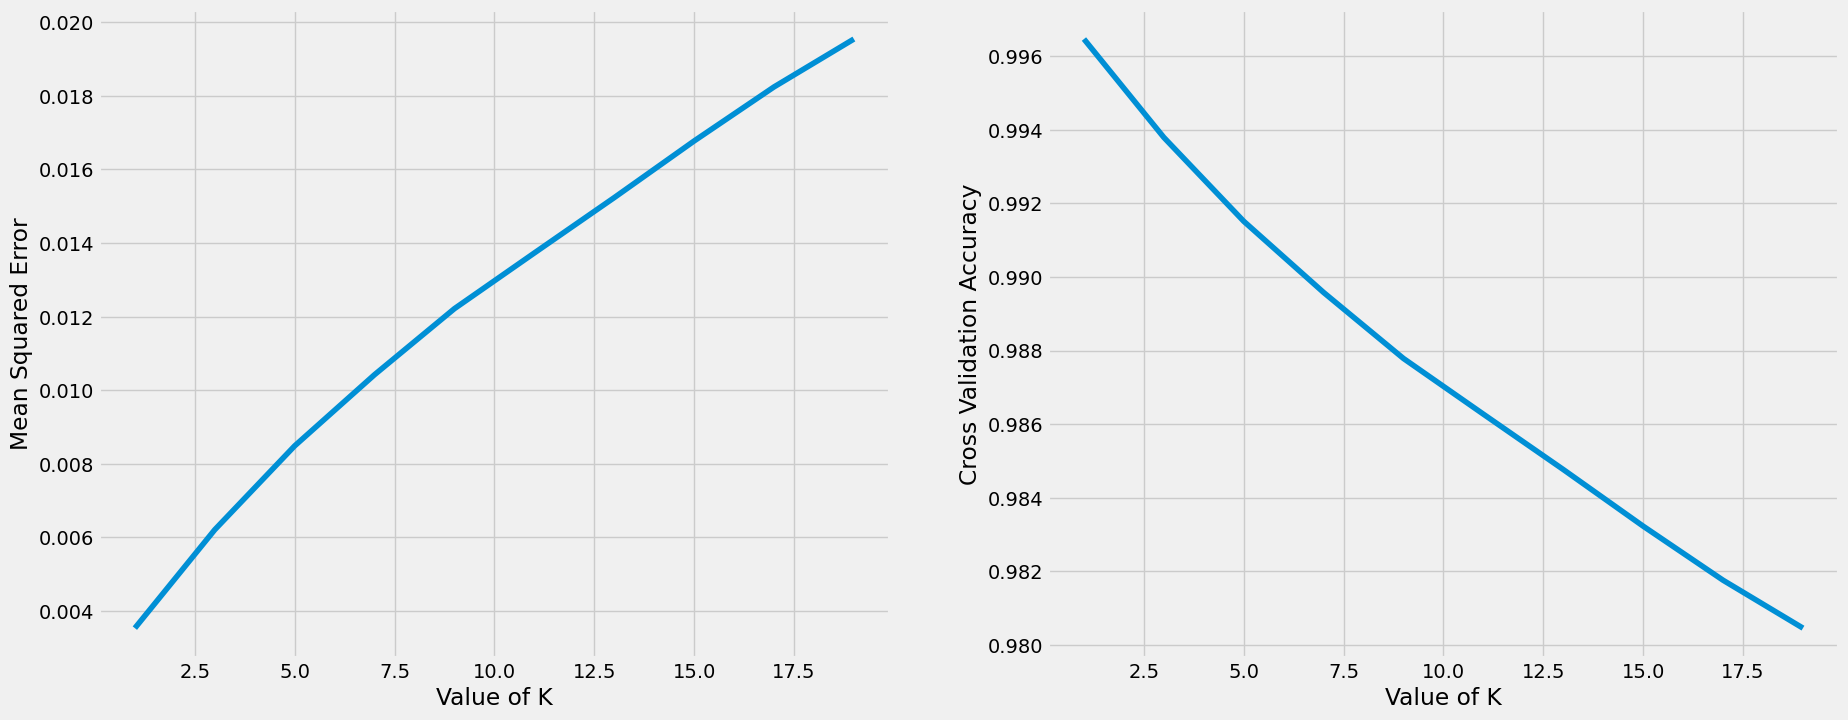

CPU times: user 4min 47s, sys: 3.99 s, total: 4min 51s
Wall time: 2min 40s


In [157]:
%%time
knn_ada_model, knn_ada_pred = KNN(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)

### Neural Network

Epoch 1/10
14214/14214 [==============================] - 214s 15ms/step - loss: 0.3356 - accuracy: 0.8556 - val_loss: 0.2342 - val_accuracy: 0.9003
Epoch 2/10
14214/14214 [==============================] - 215s 15ms/step - loss: 0.2962 - accuracy: 0.8768 - val_loss: 0.2371 - val_accuracy: 0.8959
Epoch 3/10
14214/14214 [==============================] - 213s 15ms/step - loss: 0.2953 - accuracy: 0.8775 - val_loss: 0.2357 - val_accuracy: 0.8994
Epoch 4/10
14214/14214 [==============================] - 208s 15ms/step - loss: 0.2943 - accuracy: 0.8771 - val_loss: 0.2401 - val_accuracy: 0.8977
Epoch 5/10
14214/14214 [==============================] - 201s 14ms/step - loss: 0.2946 - accuracy: 0.8766 - val_loss: 0.2384 - val_accuracy: 0.9002
Epoch 6/10
14214/14214 [==============================] - 197s 14ms/step - loss: 0.2958 - accuracy: 0.8758 - val_loss: 0.2438 - val_accuracy: 0.8988
Epoch 7/10
14214/14214 [==============================] - 196s 14ms/step - loss: 0.2930 - accuracy: 0.8777

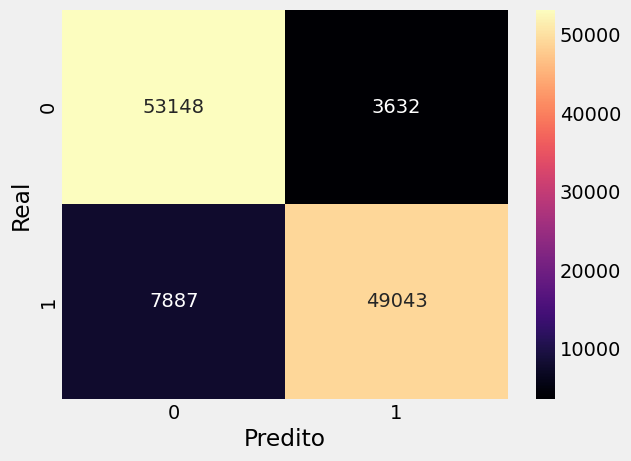

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 184       
                                                                 
 batch_normalization_16 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 8)                 0         
                                                                 
 layer2 (Dense)              (None, 3)                 27        
                                                                 
 batch_normalization_17 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 3)                

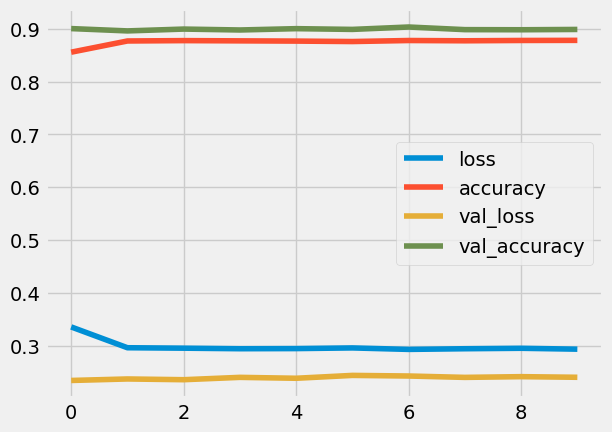

In [158]:
%%time
nn_ada_model, nn_ada_pred = NN(ada_X_train, ada_y_train, ada_X_test, ada_y_test, 10, XAI.NONE)

### Machine Ensemble


########## Random Forest ##########

########## Accuracy Score ##########
Acurácia:  0.9324245888664145

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     60158
           1       0.90      0.96      0.93     53552

    accuracy                           0.93    113710
   macro avg       0.93      0.93      0.93    113710
weighted avg       0.93      0.93      0.93    113710


########## Confusion Matrix ##########
[[54627  2153]
 [ 5531 51399]]


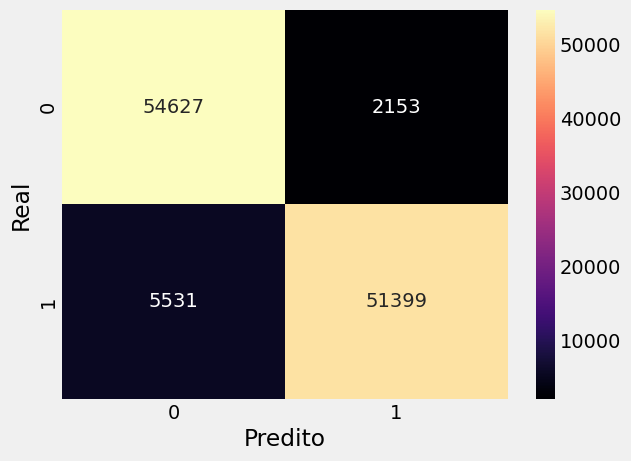


########## Logistic Regression ##########

########## Accuracy Score ##########
Acurácia:  0.9145633629408143

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     59801
           1       0.89      0.94      0.91     53909

    accuracy                           0.91    113710
   macro avg       0.91      0.92      0.91    113710
weighted avg       0.92      0.91      0.91    113710


########## Confusion Matrix ##########
[[53433  3347]
 [ 6368 50562]]


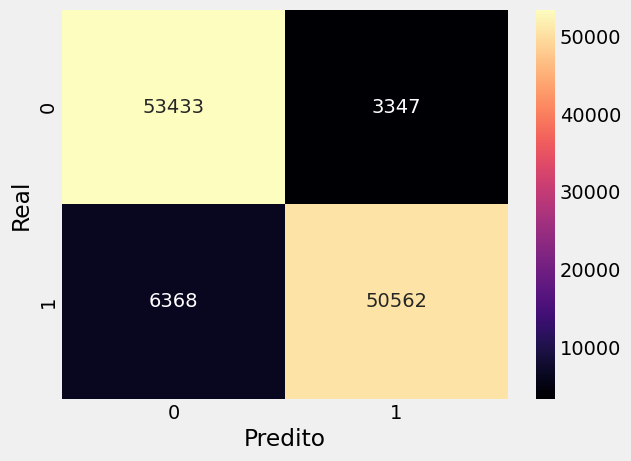


########## KNN ##########

########## Accuracy Score ##########
Acurácia:  0.9950048368657111

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56216
           1       1.00      0.99      1.00     57494

    accuracy                           1.00    113710
   macro avg       0.99      1.00      1.00    113710
weighted avg       1.00      1.00      1.00    113710


########## Confusion Matrix ##########
[[56214   566]
 [    2 56928]]


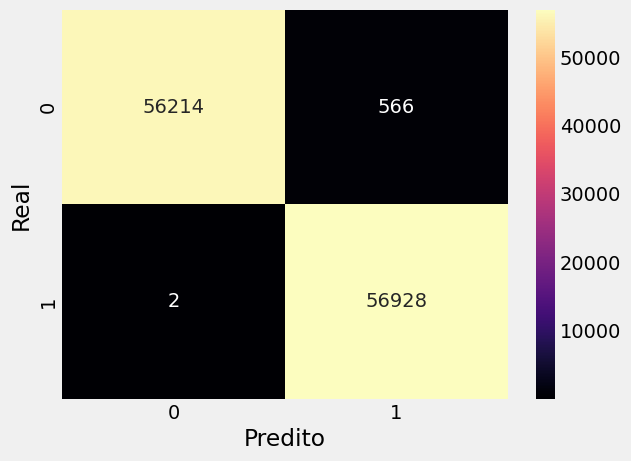

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



########## Ensemble Vote Classifier ##########

########## Accuracy Score ##########
Acurácia:  0.9764400668366898

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     57931
           1       0.97      0.99      0.98     55779

    accuracy                           0.98    113710
   macro avg       0.98      0.98      0.98    113710
weighted avg       0.98      0.98      0.98    113710


########## Confusion Matrix ##########
[[56016   764]
 [ 1915 55015]]


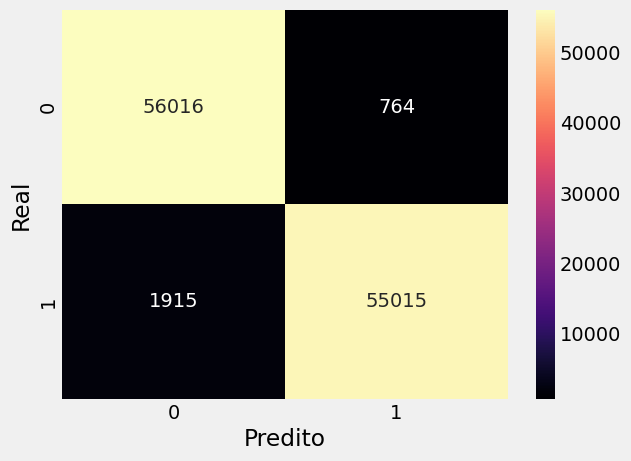

CPU times: user 5min 7s, sys: 4.25 s, total: 5min 12s
Wall time: 51.8 s


In [159]:
%%time
evc_ada_model, evc_ada_pred = EVC(ada_X_train, ada_y_train, ada_X_test, ada_y_test, [rf_ada_model, logR_ada_model, knn_ada_model], [rf_ada_pred, logR_ada_pred, knn_ada_pred], [1, 1, 1], XAI.NONE)

### XGBoost


########## Accuracy Score ##########
Acurácia:  0.9997273766599244

########## Classification Report ##########
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56749
           1       1.00      1.00      1.00     56961

    accuracy                           1.00    113710
   macro avg       1.00      1.00      1.00    113710
weighted avg       1.00      1.00      1.00    113710


########## Confusion Matrix ##########
[[56749    31]
 [    0 56930]]


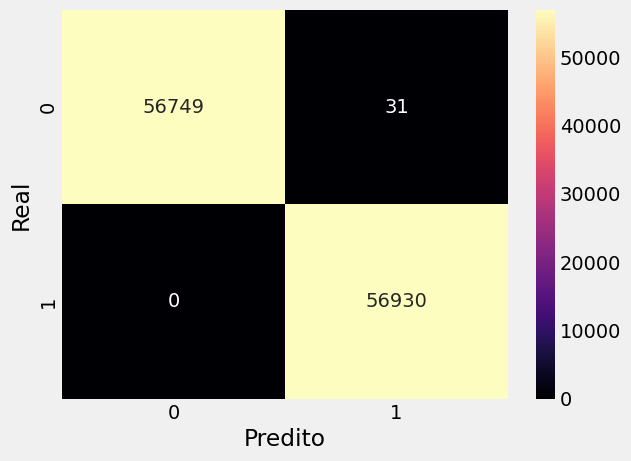

CPU times: user 10.3 s, sys: 2.99 s, total: 13.3 s
Wall time: 2.52 s


In [160]:
%%time
xgb_ada_model, xgb_ada_pred = XGB(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)

### SVC (SVM)

In [161]:
%%time
svc_ada_model, svc_ada_pred = SVC_method(ada_X_train, ada_y_train, ada_X_test, ada_y_test, XAI.NONE)

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



########## Rˆ2 Score ##########
Rˆ2 Score:  0.9053117579808284
CPU times: user 1min 45s, sys: 348 ms, total: 1min 45s
Wall time: 1min 46s


Liblinear failed to converge, increase the number of iterations.


## Undersampling e Oversampling (RUS-ADASYN)

### Linear Regression

In [162]:
%%time
lr_rusada_model, lr_rusada_pred = Linear_Regression(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  0.4956618419051705
CPU times: user 597 ms, sys: 154 ms, total: 751 ms
Wall time: 112 ms


### Multivariate Linear Regression

In [163]:
%%time
mlr_rusada_model, mlr_rusada_pred = Multivariate_Linear_Regression(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)


########## Rˆ2 Score ##########
Rˆ2 Score:  -4.672051124485578e+26
CPU times: user 587 ms, sys: 291 ms, total: 878 ms
Wall time: 122 ms


### Logistic Regression


########## Accuracy Score ##########
Acurácia:  0.8938233792751403

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1040
           1       0.87      0.91      0.89       919

    accuracy                           0.89      1959
   macro avg       0.89      0.89      0.89      1959
weighted avg       0.89      0.89      0.89      1959


########## Confusion Matrix ##########
[[918  86]
 [122 833]]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


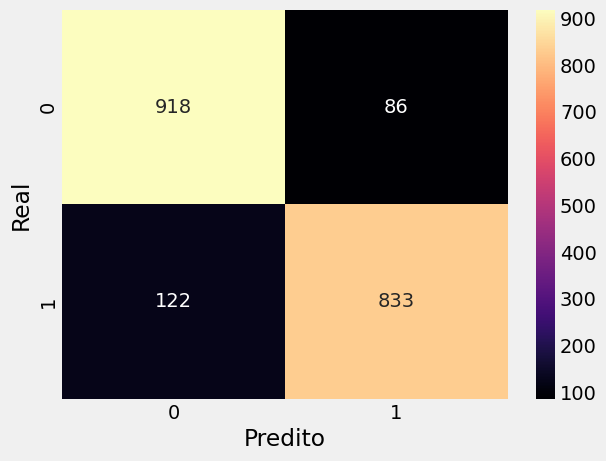

CPU times: user 1.56 s, sys: 351 ms, total: 1.91 s
Wall time: 265 ms


In [164]:
%%time
logR_rusada_model, logR_rusada_pred = Logistic_Regression(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)

### Kmeans

CPU times: user 3.25 s, sys: 2.16 s, total: 5.41 s
Wall time: 816 ms


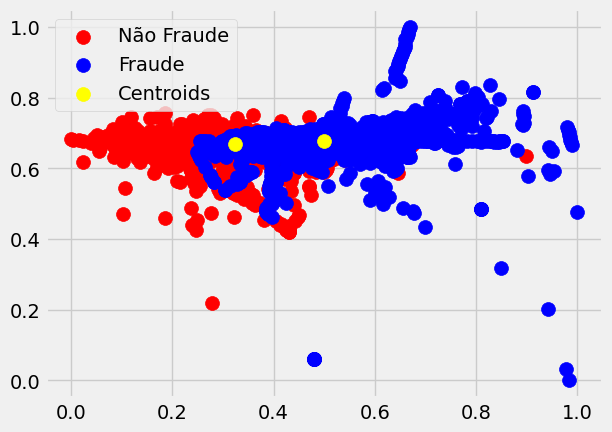

In [165]:
%%time
kmeans_rusada_model, kmeans_rusada_pred = Kmeans(X_rusada)

### Random Forest

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100

########## Accuracy Score ##########
Acurácia:  0.9943848902501277

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       999
           1       1.00      0.99      0.99       960

    accuracy                           0.99      1959
   macro avg       0.99      0.99      0.99      1959
weighted avg       0.99      0.99      0.99      1959


########## Confusion Matrix ##########
[[996   8]
 [  3 952]]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


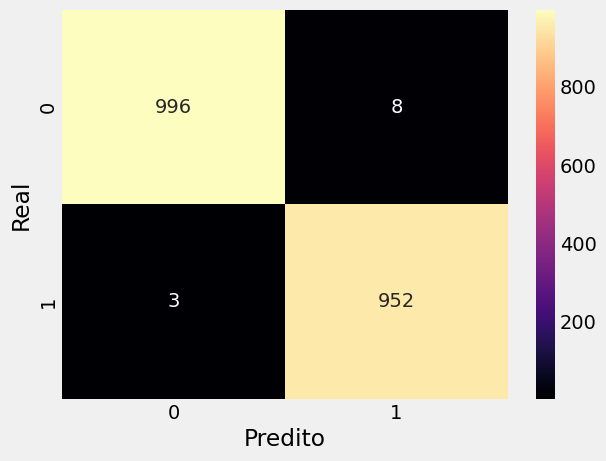

CPU times: user 1.84 s, sys: 9.94 ms, total: 1.85 s
Wall time: 1.64 s


In [166]:
%%time
rf_rusada_model, rf_rusada_pred = RandomForest(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, 500, 100, XAI.NONE)

### Decision Tree


########## Accuracy Score ##########
Acurácia:  0.9218989280245024

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       959
           1       0.94      0.90      0.92      1000

    accuracy                           0.92      1959
   macro avg       0.92      0.92      0.92      1959
weighted avg       0.92      0.92      0.92      1959


########## Confusion Matrix ##########
[[905  99]
 [ 54 901]]


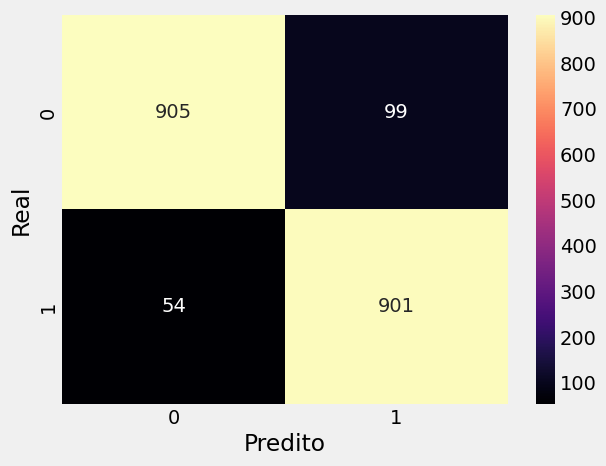

CPU times: user 1.06 s, sys: 538 ms, total: 1.6 s
Wall time: 3.31 s


In [167]:
%%time
dt_rusada_model, dt_rusada_pred = DecisionTree(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)

### KNN


########## Accuracy Score ##########
Acurácia:  0.9295558958652373

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       880
           1       0.99      0.88      0.93      1079

    accuracy                           0.93      1959
   macro avg       0.93      0.94      0.93      1959
weighted avg       0.94      0.93      0.93      1959


########## Confusion Matrix ##########
[[873 131]
 [  7 948]]


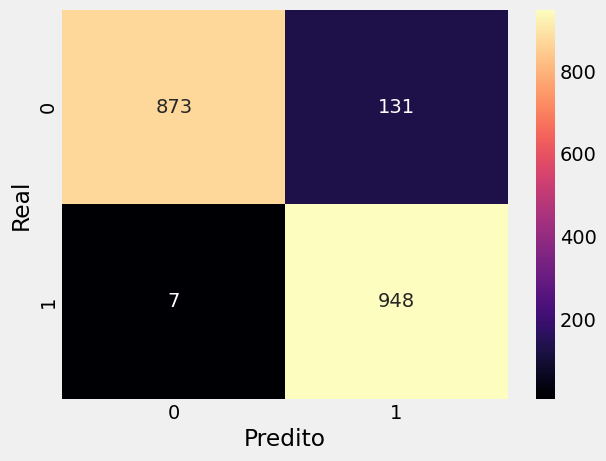

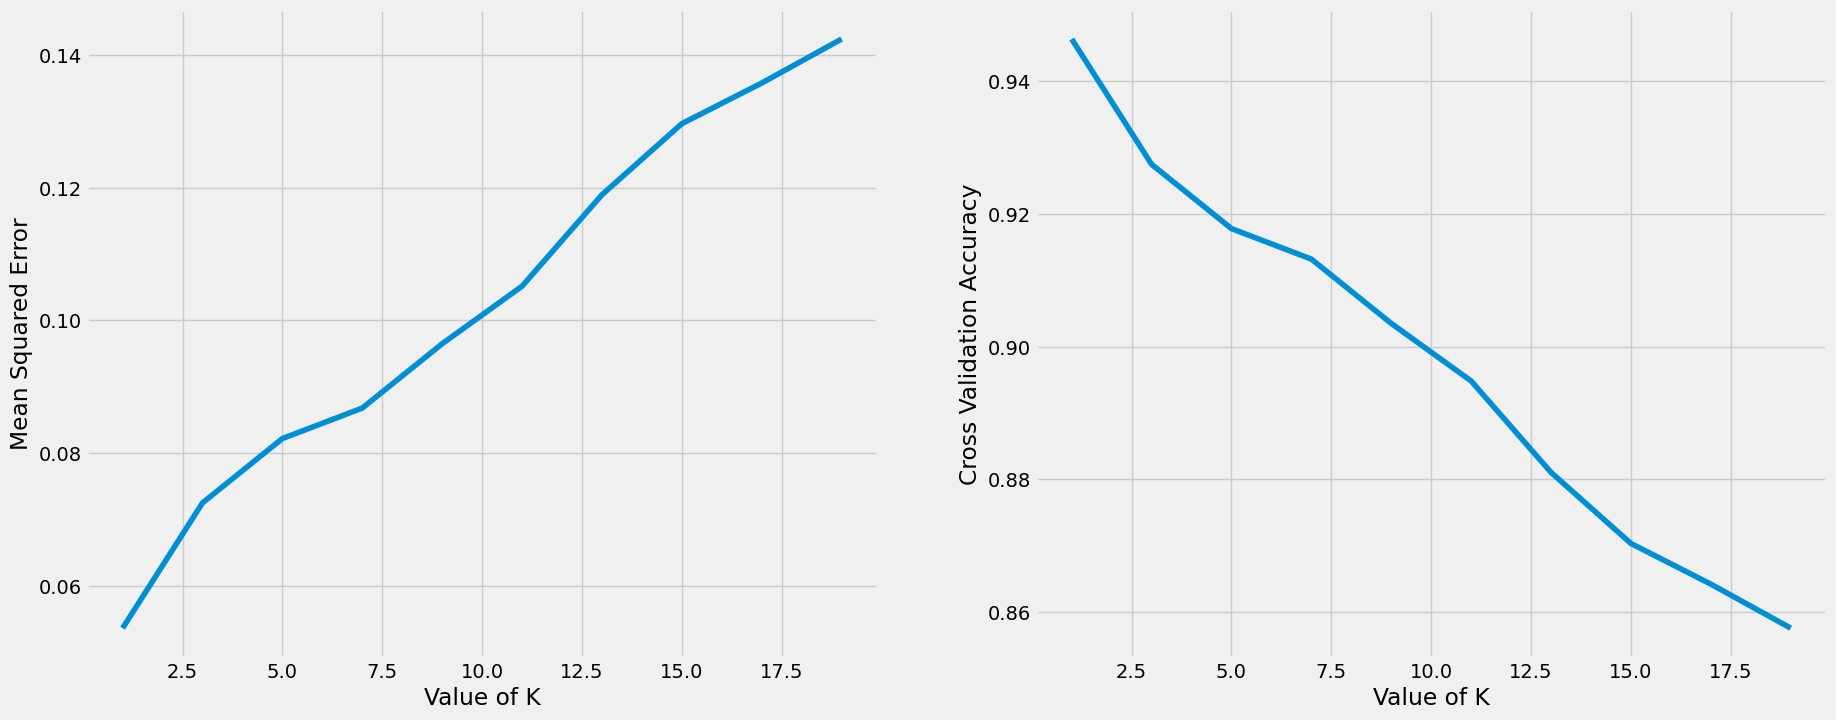

CPU times: user 2.11 s, sys: 1.68 s, total: 3.79 s
Wall time: 6.63 s


In [168]:
%%time
knn_rusada_model, knn_rusada_pred = KNN(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)

### Neural Network

Epoch 1/25
245/245 [==============================] - 6s 21ms/step - loss: 0.8264 - accuracy: 0.5441 - val_loss: 0.6300 - val_accuracy: 0.6738
Epoch 2/25
245/245 [==============================] - 4s 15ms/step - loss: 0.6494 - accuracy: 0.6393 - val_loss: 0.5869 - val_accuracy: 0.7330
Epoch 3/25
245/245 [==============================] - 4s 15ms/step - loss: 0.5710 - accuracy: 0.6976 - val_loss: 0.5182 - val_accuracy: 0.8132
Epoch 4/25
245/245 [==============================] - 4s 16ms/step - loss: 0.5247 - accuracy: 0.7229 - val_loss: 0.4526 - val_accuracy: 0.8453
Epoch 5/25
245/245 [==============================] - 4s 15ms/step - loss: 0.5081 - accuracy: 0.7483 - val_loss: 0.4187 - val_accuracy: 0.8520
Epoch 6/25
245/245 [==============================] - 4s 14ms/step - loss: 0.4588 - accuracy: 0.7834 - val_loss: 0.3808 - val_accuracy: 0.8571
Epoch 7/25
245/245 [==============================] - 4s 14ms/step - loss: 0.4379 - accuracy: 0.7982 - val_loss: 0.3570 - val_accuracy: 0.8698

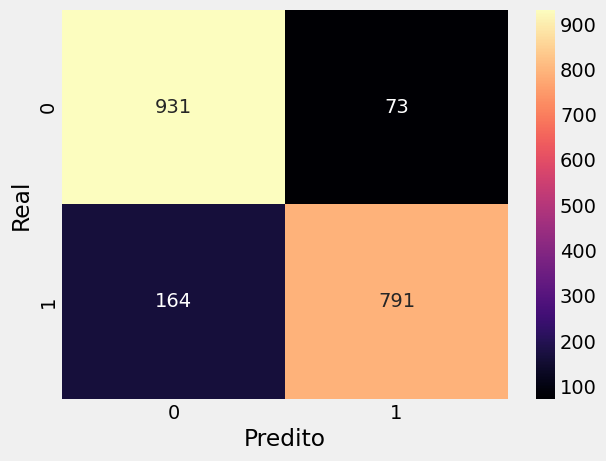

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 184       
                                                                 
 batch_normalization_18 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 8)                 0         
                                                                 
 layer2 (Dense)              (None, 3)                 27        
                                                                 
 batch_normalization_19 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 3)                

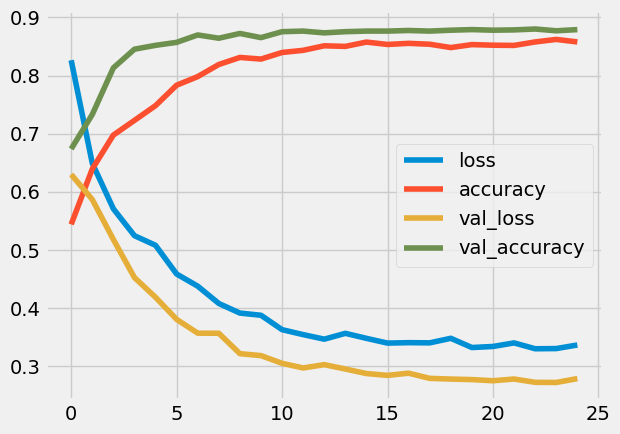

In [169]:
%%time
# Este modelo está parando de aprender na epoch 20
nn_rusada_model, nn_rusada_pred = NN(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, 25, XAI.NONE)

### Machine Ensemble


########## Random Forest ##########

########## Accuracy Score ##########
Acurácia:  0.9943848902501277

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       999
           1       1.00      0.99      0.99       960

    accuracy                           0.99      1959
   macro avg       0.99      0.99      0.99      1959
weighted avg       0.99      0.99      0.99      1959


########## Confusion Matrix ##########
[[996   8]
 [  3 952]]


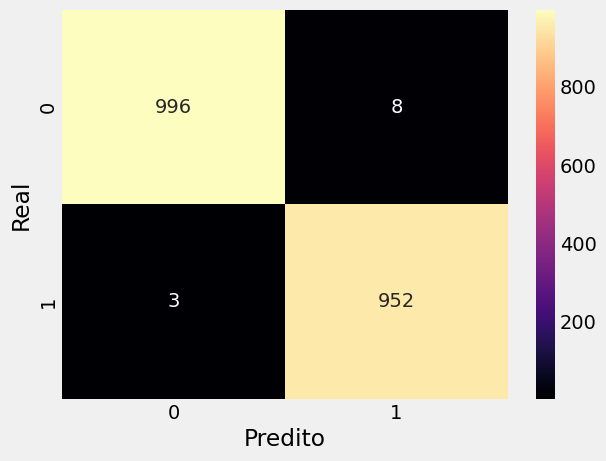


########## Logistic Regression ##########

########## Accuracy Score ##########
Acurácia:  0.8938233792751403

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1040
           1       0.87      0.91      0.89       919

    accuracy                           0.89      1959
   macro avg       0.89      0.89      0.89      1959
weighted avg       0.89      0.89      0.89      1959


########## Confusion Matrix ##########
[[918  86]
 [122 833]]


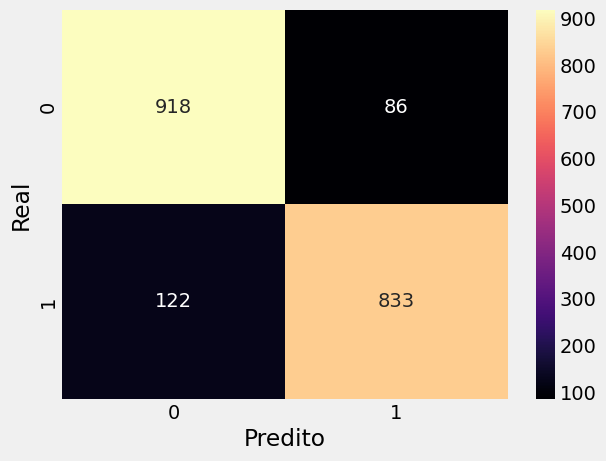


########## KNN ##########

########## Accuracy Score ##########
Acurácia:  0.9295558958652373

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       880
           1       0.99      0.88      0.93      1079

    accuracy                           0.93      1959
   macro avg       0.93      0.94      0.93      1959
weighted avg       0.94      0.93      0.93      1959


########## Confusion Matrix ##########
[[873 131]
 [  7 948]]


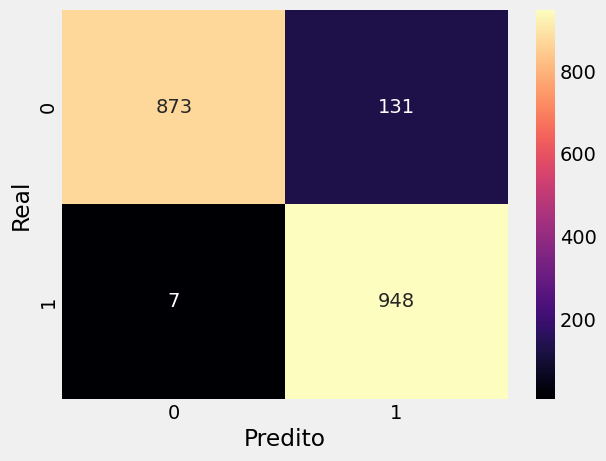

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s



########## Ensemble Vote Classifier ##########

########## Accuracy Score ##########
Acurácia:  0.9765186319550792

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.96      0.98       993

    accuracy                           0.98      1959
   macro avg       0.98      0.98      0.98      1959
weighted avg       0.98      0.98      0.98      1959


########## Confusion Matrix ##########
[[962  42]
 [  4 951]]


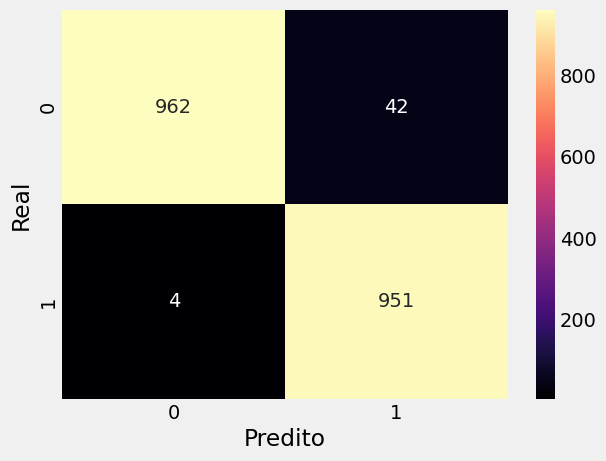

CPU times: user 4.66 s, sys: 336 ms, total: 5 s
Wall time: 2.16 s


In [170]:
%%time
evc_rusada_model, evc_rusada_pred = EVC(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, [rf_rusada_model, logR_rusada_model, knn_rusada_model], [rf_rusada_pred, logR_rusada_pred, knn_rusada_pred], [1, 1, 1], XAI.NONE)

### XGBoost


########## Accuracy Score ##########
Acurácia:  0.9913221031138336

########## Classification Report ##########
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       989
           1       1.00      0.98      0.99       970

    accuracy                           0.99      1959
   macro avg       0.99      0.99      0.99      1959
weighted avg       0.99      0.99      0.99      1959


########## Confusion Matrix ##########
[[988  16]
 [  1 954]]


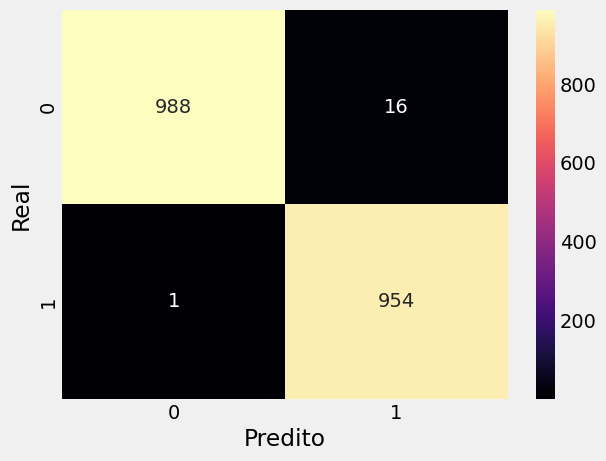

CPU times: user 1.19 s, sys: 472 ms, total: 1.67 s
Wall time: 265 ms


In [171]:
%%time
xgb_rusada_model, xgb_rusada_pred = XGB(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)

### SVC (SVM)

In [172]:
%%time
svc_rusada_model, svc_rusada_pred = SVC_method(rusada_X_train, rusada_y_train, rusada_X_test, rusada_y_test, XAI.NONE)

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



########## Rˆ2 Score ##########
Rˆ2 Score:  0.8095967330270546
CPU times: user 939 ms, sys: 202 ms, total: 1.14 s
Wall time: 364 ms


Liblinear failed to converge, increase the number of iterations.


# Comparativo das técnicas

In [106]:
def acc_plot(type, acc_nn, acc_knn, acc_logR, acc_dt, acc_rf, acc_evc, acc_xgb, acc_svc):
    # Dados de exemplo
    models = [ 'Neural\nNetwork', 'KNN', 'Logistic\nRegression', 'Decision\nTree', 'Random\nForest', 'Ensemble\nVote\nClassifier', 'XGBoost', 'SVM\n(svc)']
    acurracies = [acc_nn, acc_knn, acc_logR, acc_dt, acc_rf, acc_evc, acc_xgb, acc_svc]

    # Criando o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(models, acurracies, color='skyblue')

    # Adicionando título e rótulos
    plt.title(f'Acurácia dos Modelos Implementados ({type})')
    plt.xlabel('Modelos')
    plt.ylabel('Acurácia')

    # Exibindo o gráfico
    plt.show()


########## Accuracy Score ##########
Acurácia:  0.9991573329588147

########## Accuracy Score ##########
Acurácia:  0.9994908886626171

########## Accuracy Score ##########
Acurácia:  0.999385555282469

########## Accuracy Score ##########
Acurácia:  0.9990871107053826

########## Accuracy Score ##########
Acurácia:  0.9992099996488887

########## Accuracy Score ##########
Acurácia:  0.9995962220427653


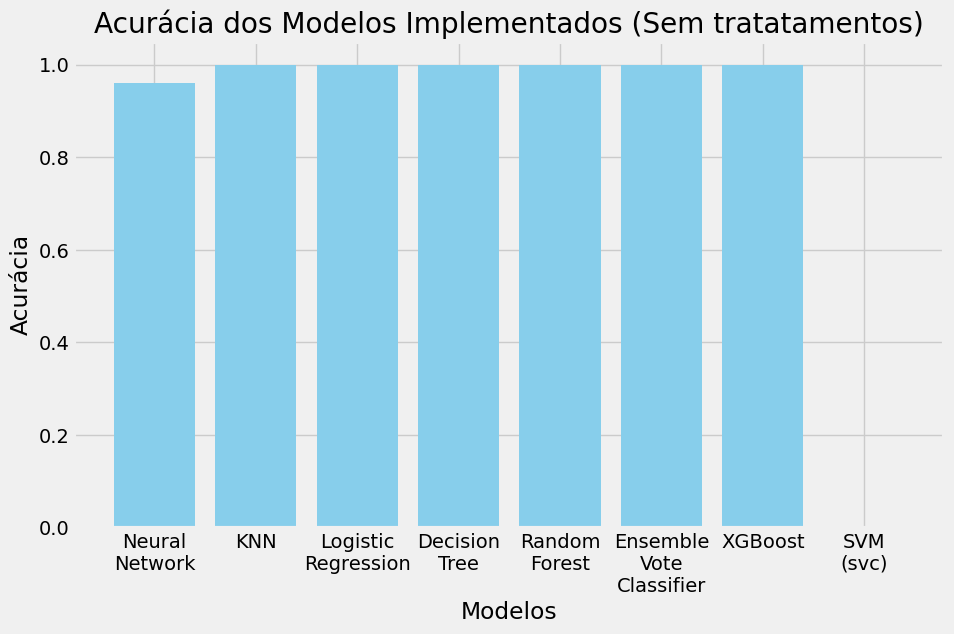

In [173]:
acc_logR = acc_score(logR_pred, y_test)
acc_dt = acc_score(dt_pred, y_test)
acc_rf = acc_score(rf_pred, y_test)
acc_knn = acc_score(knn_pred, y_test)
acc_evc = acc_score(evc_pred, y_test)
acc_xgb = acc_score(xgb_pred, y_test)

acc_svc = 0.0 # acc_score(svc_pred, y_test, False)

acc_nn = 0.96 # valor obtido durante a primeira epoch
# acc_score(nn_red, y_test, False)

acc_plot('Sem tratatamentos', acc_nn, acc_knn, acc_logR, acc_dt, acc_rf, acc_evc, acc_xgb, acc_svc)

In [177]:
# Pegando os dados

# Rˆ2
# Linear Regression
#model.score(X_test, y_test)
lr_r2 = lr_model.score(X_test, y_test)
lr_sub_r2 = lr_sub_model.score(sub_X_test, sub_y_test)
lr_smote_r2 = lr_smote_model.score(smote_X_test, smote_y_test)
lr_ada_r2 = lr_ada_model.score(ada_X_test, ada_y_test)
lr_rusada_r2 = lr_rusada_model.score(rusada_X_test, rusada_y_test)
# Multivariate Linear Regression
mlr_r2 = mlr_model.score(X_test, y_test)
mlr_sub_r2 = mlr_sub_model.score(sub_X_test, sub_y_test)
mlr_smote_r2 = mlr_smote_model.score(smote_X_test, smote_y_test)
mlr_ada_r2 = mlr_ada_model.score(ada_X_test, ada_y_test)
mlr_rusada_r2 = mlr_rusada_model.score(rusada_X_test, rusada_y_test)

# Acurácia
# Logistic Regression
logR_acc = accuracy_score(logR_pred, y_test)
logR_sub_acc = acc_score(logR_sub_pred, sub_y_test)
logR_smote_acc = acc_score(logR_smote_pred, smote_y_test)
logR_ada_acc = acc_score(logR_ada_pred, ada_y_test)
logR_rusada_acc = acc_score(logR_rusada_pred, rusada_y_test)
# Random Forest
rf_acc = acc_score(rf_pred, y_test)
rf_sub_acc = acc_score(rf_sub_pred, sub_y_test)
rf_smote_acc = acc_score(rf_smote_pred, smote_y_test)
rf_ada_acc = acc_score(rf_ada_pred, ada_y_test)
rf_rusada_acc = acc_score(rf_rusada_pred, rusada_y_test)
# Decision Tree
dt_acc = acc_score(dt_pred, y_test)
dt_sub_acc = acc_score(dt_sub_pred, sub_y_test)
dt_smote_acc = acc_score(dt_smote_pred, smote_y_test)
dt_ada_acc = acc_score(dt_ada_pred, ada_y_test)
dt_rusada_acc = acc_score(dt_rusada_pred, rusada_y_test)
# KNN
knn_acc = acc_score(knn_pred, y_test)
knn_sub_acc = acc_score(knn_sub_pred, sub_y_test)
knn_smote_acc = acc_score(knn_smote_pred, smote_y_test)
knn_ada_acc = acc_score(knn_ada_pred, ada_y_test)
knn_rusada_acc = acc_score(knn_rusada_pred, rusada_y_test)
# Neural Network
nn_acc = acc_score(nn_pred, y_test)
nn_sub_acc = acc_score(nn_sub_pred, sub_y_test)
nn_smote_acc = acc_score(nn_smote_pred, smote_y_test)
nn_ada_acc = acc_score(nn_ada_pred, ada_y_test)
nn_rusada_acc = acc_score(nn_rusada_pred, rusada_y_test)
# Machine Ensemble
evc_acc = acc_score(evc_pred, y_test)
evc_sub_acc = acc_score(evc_sub_pred, sub_y_test)
evc_smote_acc = acc_score(evc_smote_pred, smote_y_test)
evc_ada_acc = acc_score(evc_ada_pred, ada_y_test)
evc_rusada_acc = acc_score(evc_rusada_pred, rusada_y_test)
# XGBoost
xgb_acc = acc_score(xgb_pred, y_test)
xgb_sub_acc = acc_score(xgb_sub_pred, sub_y_test)
xgb_smote_acc = acc_score(xgb_smote_pred, smote_y_test)
xgb_ada_acc = acc_score(xgb_ada_pred, ada_y_test)
xgb_rusada_acc = acc_score(xgb_rusada_pred, rusada_y_test)
# SVC
svc_acc = acc_score(svc_pred, y_test)
svc_sub_acc = acc_score(svc_sub_pred, sub_y_test)
svc_smote_acc = acc_score(svc_smote_pred, smote_y_test)
svc_ada_acc = acc_score(svc_ada_pred, ada_y_test)
svc_rusada_acc = acc_score(svc_rusada_pred, rusada_y_test)

# F1 Score
# Logistic Regression
logR_report = classification_report(y_test, logR_pred, output_dict=True)
logR_f1 = logR_report['macro avg']['f1-score']
logR_sub_report = classification_report(sub_y_test, logR_sub_pred, output_dict=True)
logR_sub_f1 = logR_sub_report['macro avg']['f1-score']
logR_smote_report = classification_report(smote_y_test, logR_smote_pred, output_dict=True)
logR_smote_f1 = logR_smote_report['macro avg']['f1-score']
logR_ada_report = classification_report(ada_y_test, logR_ada_pred, output_dict=True)
logR_ada_f1 = logR_ada_report['macro avg']['f1-score']
logR_rusada_report = classification_report(rusada_y_test, logR_rusada_pred, output_dict=True)
logR_rusada_f1 = logR_rusada_report['macro avg']['f1-score']
# Random Forest
rf_report = classification_report(y_test, rf_pred, output_dict=True)
rf_f1 = rf_report['macro avg']['f1-score']
rf_sub_report = classification_report(sub_y_test, rf_sub_pred, output_dict=True)
rf_sub_f1 = rf_sub_report['macro avg']['f1-score']
rf_smote_report = classification_report(smote_y_test, rf_smote_pred, output_dict=True)
rf_smote_f1 = rf_smote_report['macro avg']['f1-score']
rf_ada_report = classification_report(ada_y_test, rf_ada_pred, output_dict=True)
rf_ada_f1 = rf_ada_report['macro avg']['f1-score']
rf_rusada_report = classification_report(rusada_y_test, rf_rusada_pred, output_dict=True)
rf_rusada_f1 = rf_rusada_report['macro avg']['f1-score']
# Decision Tree
dt_report = classification_report(y_test, dt_pred, output_dict=True)
dt_f1 = dt_report['macro avg']['f1-score']
dt_sub_report = classification_report(sub_y_test, dt_sub_pred, output_dict=True)
dt_sub_f1 = dt_sub_report['macro avg']['f1-score']
dt_smote_report = classification_report(smote_y_test, dt_smote_pred, output_dict=True)
dt_smote_f1 = dt_smote_report['macro avg']['f1-score']
dt_ada_report = classification_report(ada_y_test, dt_ada_pred, output_dict=True)
dt_ada_f1 = dt_ada_report['macro avg']['f1-score']
dt_rusada_report = classification_report(rusada_y_test, dt_rusada_pred, output_dict=True)
dt_rusada_f1 = dt_rusada_report['macro avg']['f1-score']
# KNN
knn_report = classification_report(y_test, knn_pred, output_dict=True)
knn_f1 = knn_report['macro avg']['f1-score']
knn_sub_report = classification_report(sub_y_test, knn_sub_pred, output_dict=True)
knn_sub_f1 = knn_sub_report['macro avg']['f1-score']
knn_smote_report = classification_report(smote_y_test, knn_smote_pred, output_dict=True)
knn_smote_f1 = knn_smote_report['macro avg']['f1-score']
knn_ada_report = classification_report(ada_y_test, knn_ada_pred, output_dict=True)
knn_ada_f1 = knn_ada_report['macro avg']['f1-score']
knn_rusada_report = classification_report(rusada_y_test, knn_rusada_pred, output_dict=True)
knn_rusada_f1 = knn_rusada_report['macro avg']['f1-score']
# Neural Network
nn_report = classification_report(y_test, nn_pred, output_dict=True)
nn_f1 = nn_report['macro avg']['f1-score']
nn_sub_report = classification_report(sub_y_test, nn_sub_pred, output_dict=True)
nn_sub_f1 = nn_sub_report['macro avg']['f1-score']
nn_smote_report = classification_report(smote_y_test, nn_smote_pred, output_dict=True)
nn_smote_f1 = nn_smote_report['macro avg']['f1-score']
nn_ada_report = classification_report(ada_y_test, nn_ada_pred, output_dict=True)
nn_ada_f1 = nn_ada_report['macro avg']['f1-score']
nn_rusada_report = classification_report(rusada_y_test, nn_rusada_pred, output_dict=True)
nn_rusada_f1 = nn_rusada_report['macro avg']['f1-score']
# Machine Ensemble
evc_report = classification_report(y_test, evc_pred, output_dict=True)
evc_f1 = evc_report['macro avg']['f1-score']
evc_sub_report = classification_report(sub_y_test, evc_sub_pred, output_dict=True)
evc_sub_f1 = evc_sub_report['macro avg']['f1-score']
evc_smote_report = classification_report(smote_y_test, evc_smote_pred, output_dict=True)
evc_smote_f1 = evc_smote_report['macro avg']['f1-score']
evc_ada_report = classification_report(ada_y_test, evc_ada_pred, output_dict=True)
evc_ada_f1 = evc_ada_report['macro avg']['f1-score']
evc_rusada_report = classification_report(rusada_y_test, evc_rusada_pred, output_dict=True)
evc_rusada_f1 = evc_rusada_report['macro avg']['f1-score']
# XGBoost
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)
xgb_f1 = xgb_report['macro avg']['f1-score']
xgb_sub_report = classification_report(sub_y_test, xgb_sub_pred, output_dict=True)
xgb_sub_f1 = xgb_sub_report['macro avg']['f1-score']
xgb_smote_report = classification_report(smote_y_test, xgb_smote_pred, output_dict=True)
xgb_smote_f1 = xgb_smote_report['macro avg']['f1-score']
xgb_ada_report = classification_report(ada_y_test, xgb_ada_pred, output_dict=True)
xgb_ada_f1 = xgb_ada_report['macro avg']['f1-score']
xgb_rusada_report = classification_report(rusada_y_test, xgb_rusada_pred, output_dict=True)
xgb_rusada_f1 = xgb_rusada_report['macro avg']['f1-score']
# SVC
svc_report = classification_report(y_test, svc_pred, output_dict=True)
svc_f1 = svc_report['macro avg']['f1-score']
svc_sub_report = classification_report(sub_y_test, svc_sub_pred, output_dict=True)
svc_sub_f1 = svc_sub_report['macro avg']['f1-score']
svc_smote_report = classification_report(smote_y_test, svc_smote_pred, output_dict=True)
svc_smote_f1 = svc_smote_report['macro avg']['f1-score']
svc_ada_report = classification_report(ada_y_test, svc_ada_pred, output_dict=True)
svc_ada_f1 = svc_ada_report['macro avg']['f1-score']
svc_rusada_report = classification_report(rusada_y_test, svc_rusada_pred, output_dict=True)
svc_rusada_f1 = svc_rusada_report['macro avg']['f1-score']
print(lr_r2)



########## Accuracy Score ##########
Acurácia:  0.9390862944162437

########## Accuracy Score ##########
Acurácia:  0.9578196718428503

########## Accuracy Score ##########
Acurácia:  0.9145633629408143

########## Accuracy Score ##########
Acurácia:  0.8938233792751403

########## Accuracy Score ##########
Acurácia:  0.999385555282469

########## Accuracy Score ##########
Acurácia:  0.9238578680203046

########## Accuracy Score ##########
Acurácia:  0.9560258867805075

########## Accuracy Score ##########
Acurácia:  0.9324245888664145

########## Accuracy Score ##########
Acurácia:  0.9943848902501277

########## Accuracy Score ##########
Acurácia:  0.9994908886626171

########## Accuracy Score ##########
Acurácia:  0.9137055837563451

########## Accuracy Score ##########
Acurácia:  0.964361711481983

########## Accuracy Score ##########
Acurácia:  0.9326532407000264

########## Accuracy Score ##########
Acurácia:  0.9218989280245024

########## Accuracy Score ##########
Acurácia:  0

In [175]:
f1 = f1_score(y_test, knn_pred)
report = classification_report(y_test, knn_pred, output_dict=True)

macro_precision =  report['macro avg']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']
print(report)

{'0': {'precision': 0.9991389913899139, 'recall': 0.9999472425436128, 'f1-score': 0.9995429535746304, 'support': 56864.0}, '1': {'precision': 0.9423076923076923, 'recall': 0.5, 'f1-score': 0.6533333333333333, 'support': 98.0}, 'accuracy': 0.9990871107053826, 'macro avg': {'precision': 0.970723341848803, 'recall': 0.7499736212718064, 'f1-score': 0.8264381434539818, 'support': 56962.0}, 'weighted avg': {'precision': 0.9990412162536818, 'recall': 0.9990871107053826, 'f1-score': 0.9989473188921465, 'support': 56962.0}}


In [178]:
# criando dataframe

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['model_technique', 'score_type', 'value']
    df['sampling_technique'] = name
    return df



score_types = [
                'Rˆ2 Score',
                'Acurácia',
                'F1 Score'
            ]
model_techniques = [
                    'Linear Regression',
                    'Multivariate Linear Regression',
                    'Logistic Regression',
                    'Random Forest',
                    'Decision Tree',
                    'KNN',
                    'Neural Network',
                    'Ensemble',
                    'XGBoost',
                    'SVC'
                    ]
sampling_techniques = [
                      'Standard',
                      'Subsampling',
                      'SMOTE',
                      'ADASYN',
                      'RUS-ADASYN'
                      ]

# mocks
std_mock = [ #R2, Acc, F1
                [0.3, 0, 0], #LR
                [0.4, 0, 0], #MLR
                [0, 0.7, 0.7], #LogR
                [0, 0.7, 0.7], #RF
                [0, 0.7, 0.7], #DT
                [0, 0.7, 0.7], #KNN
                [0, 0.7, 0.7], #NN
                [0, 0.7, 0.7], #EVC
                [0, 0.7, 0.7], #XGB
                [0, 0.7, 0.7] #SVM
]
sub_mock = [ #R2, Acc, F1
                [0.3, 0, 0], #LR
                [0.4, 0, 0], #MLR
                [0, 0.7, 0.7], #LogR
                [0, 0.7, 0.7], #RF
                [0, 0.7, 0.7], #DT
                [0, 0.7, 0.7], #KNN
                [0, 0.7, 0.7], #NN
                [0, 0.7, 0.7], #EVC
                [0, 0.7, 0.7], #XGB
                [0, 0.7, 0.7] #SVM
]
smote_mock = [ #R2, Acc, F1
                [0.3, 0, 0], #LR
                [0.4, 0, 0], #MLR
                [0, 0.7, 0.7], #LogR
                [0, 0.7, 0.7], #RF
                [0, 0.7, 0.7], #DT
                [0, 0.7, 0.7], #KNN
                [0, 0.7, 0.7], #NN
                [0, 0.7, 0.7], #EVC
                [0, 0.7, 0.7], #XGB
                [0, 0.7, 0.7] #SVM
]
ada_mock = [ #R2, Acc, F1
                [0.3, 0, 0], #LR
                [0.4, 0, 0], #MLR
                [0, 0.7, 0.7], #LogR
                [0, 0.7, 0.7], #RF
                [0, 0.7, 0.7], #DT
                [0, 0.7, 0.7], #KNN
                [0, 0.7, 0.7], #NN
                [0, 0.7, 0.7], #EVC
                [0, 0.7, 0.7], #XGB
                [0, 0.7, 0.7] #SVM
]
rusada_mock = [ #R2, Acc, F1
                [0.3, 0, 0], #LR
                [0.4, 0, 0], #MLR
                [0, 0.7, 0.7], #LogR
                [0, 0.7, 0.7], #RF
                [0, 0.7, 0.7], #DT
                [0, 0.7, 0.7], #KNN
                [0, 0.7, 0.7], #NN
                [0, 0.7, 0.7], #EVC
                [0, 0.7, 0.7], #XGB
                [0, 0.7, 0.7] #SVM
]
# mocks
std_df = [ #R2, Acc, F1
                [lr_r2, 0, 0], #LR
                [mlr_r2, 0, 0], #MLR
                [0, logR_acc, logR_f1], #LogR
                [0, rf_acc, rf_f1], #RF
                [0, dt_acc, dt_f1], #DT
                [0, knn_acc, knn_f1], #KNN
                [0, nn_acc, nn_f1], #NN
                [0, evc_acc, evc_f1], #EVC
                [0, xgb_acc, xgb_f1], #XGB
                [0, svc_acc, svc_f1] #SVC
]
print(std_df)
sub_df = [ #R2, Acc, F1
                [lr_sub_r2, 0, 0], #LR
                [mlr_sub_r2, 0, 0], #MLR
                [0, logR_sub_acc, logR_sub_f1], #LogR
                [0, rf_sub_acc, rf_sub_f1], #RF
                [0, dt_sub_acc, dt_sub_f1], #DT
                [0, knn_sub_acc, knn_sub_f1], #KNN
                [0, nn_sub_acc, nn_sub_f1], #NN
                [0, evc_sub_acc, evc_sub_f1], #EVC
                [0, xgb_sub_acc, xgb_sub_f1], #XGB
                [0, svc_sub_acc, svc_sub_f1] #SVC
]
smote_df = [ #R2, Acc, F1
                [lr_smote_r2, 0, 0], #LR
                [mlr_smote_r2, 0, 0], #MLR
                [0, logR_smote_acc, logR_smote_f1], #LogR
                [0, rf_smote_acc, rf_smote_f1], #RF
                [0, dt_smote_acc, dt_smote_f1], #DT
                [0, knn_smote_acc, knn_smote_f1], #KNN
                [0, nn_smote_acc, nn_smote_f1], #NN
                [0, evc_smote_acc, evc_smote_f1], #EVC
                [0, xgb_smote_acc, xgb_smote_f1], #XGB
                [0, svc_smote_acc, svc_smote_f1] #SVC
]
ada_df = [ #R2, Acc, F1
                [lr_ada_r2, 0, 0], #LR
                [mlr_ada_r2, 0, 0], #MLR
                [0, logR_ada_acc, logR_ada_f1], #LogR
                [0, rf_ada_acc, rf_ada_f1], #RF
                [0, dt_ada_acc, dt_ada_f1], #DT
                [0, knn_ada_acc, knn_ada_f1], #KNN
                [0, nn_ada_acc, nn_ada_f1], #NN
                [0, evc_ada_acc, evc_ada_f1], #EVC
                [0, xgb_ada_acc, xgb_ada_f1], #XGB
                [0, svc_ada_acc, svc_ada_f1] #SVC
]
rusada_df = [ #R2, Acc, F1
                [lr_rusada_r2, 0, 0], #LR
                [mlr_rusada_r2, 0, 0], #MLR
                [0, logR_rusada_acc, logR_f1], #LogR
                [0, rf_rusada_acc, rf_rusada_f1], #RF
                [0, dt_rusada_acc, dt_rusada_f1], #DT
                [0, knn_rusada_acc, knn_rusada_f1], #KNN
                [0, nn_rusada_acc, nn_rusada_f1], #NN
                [0, evc_rusada_acc, evc_rusada_f1], #EVC
                [0, xgb_rusada_acc, xgb_rusada_f1], #XGB
                [0, svc_rusada_acc, svc_rusada_f1] #SVC
]

df_std = pd.DataFrame(std_df, index=model_techniques, columns=score_types)
df_sub = pd.DataFrame(sub_df, index=model_techniques, columns=score_types)
df_smote = pd.DataFrame(smote_df, index=model_techniques, columns=score_types)
df_ada = pd.DataFrame(ada_df, index=model_techniques, columns=score_types)
df_rusada = pd.DataFrame(rusada_df, index=model_techniques, columns=score_types)

df_std = prep_df(df_std, 'Standard')
df_sub = prep_df(df_sub, 'Subsampling')
df_smote = prep_df(df_smote, 'SMOTE')
df_ada = prep_df(df_ada, 'ADASYN')
df_rusada = prep_df(df_rusada, 'RUS-ADASYN')
df_std.head()

[[0.40763404596871966, 0, 0], [-2.6623255913317702e+29, 0, 0], [0, 0.9991573329588147, 0.8552107125737429], [0, 0.999385555282469, 0.9009760932913907], [0, 0.9994908886626171, 0.9206375447083954], [0, 0.9990871107053826, 0.8264381434539818], [0, 0.9993153330290369, 0.8998285397743759], [0, 0.9992099996488887, 0.860050667610549], [0, 0.9995962220427653, 0.9384015633402117], [0, 0.9992451107756047, 0.8769538444921965]]


,model_technique,score_type,value,sampling_technique
0,Linear Regression,Rˆ2 Score,4.076340e-01,Standard
1,Linear Regression,Acurácia,0.000000e+00,Standard
2,Linear Regression,F1 Score,0.000000e+00,Standard
3,Multivariate Linear Regression,Rˆ2 Score,-2.662326e+29,Standard
4,Multivariate Linear Regression,Acurácia,0.000000e+00,Standard


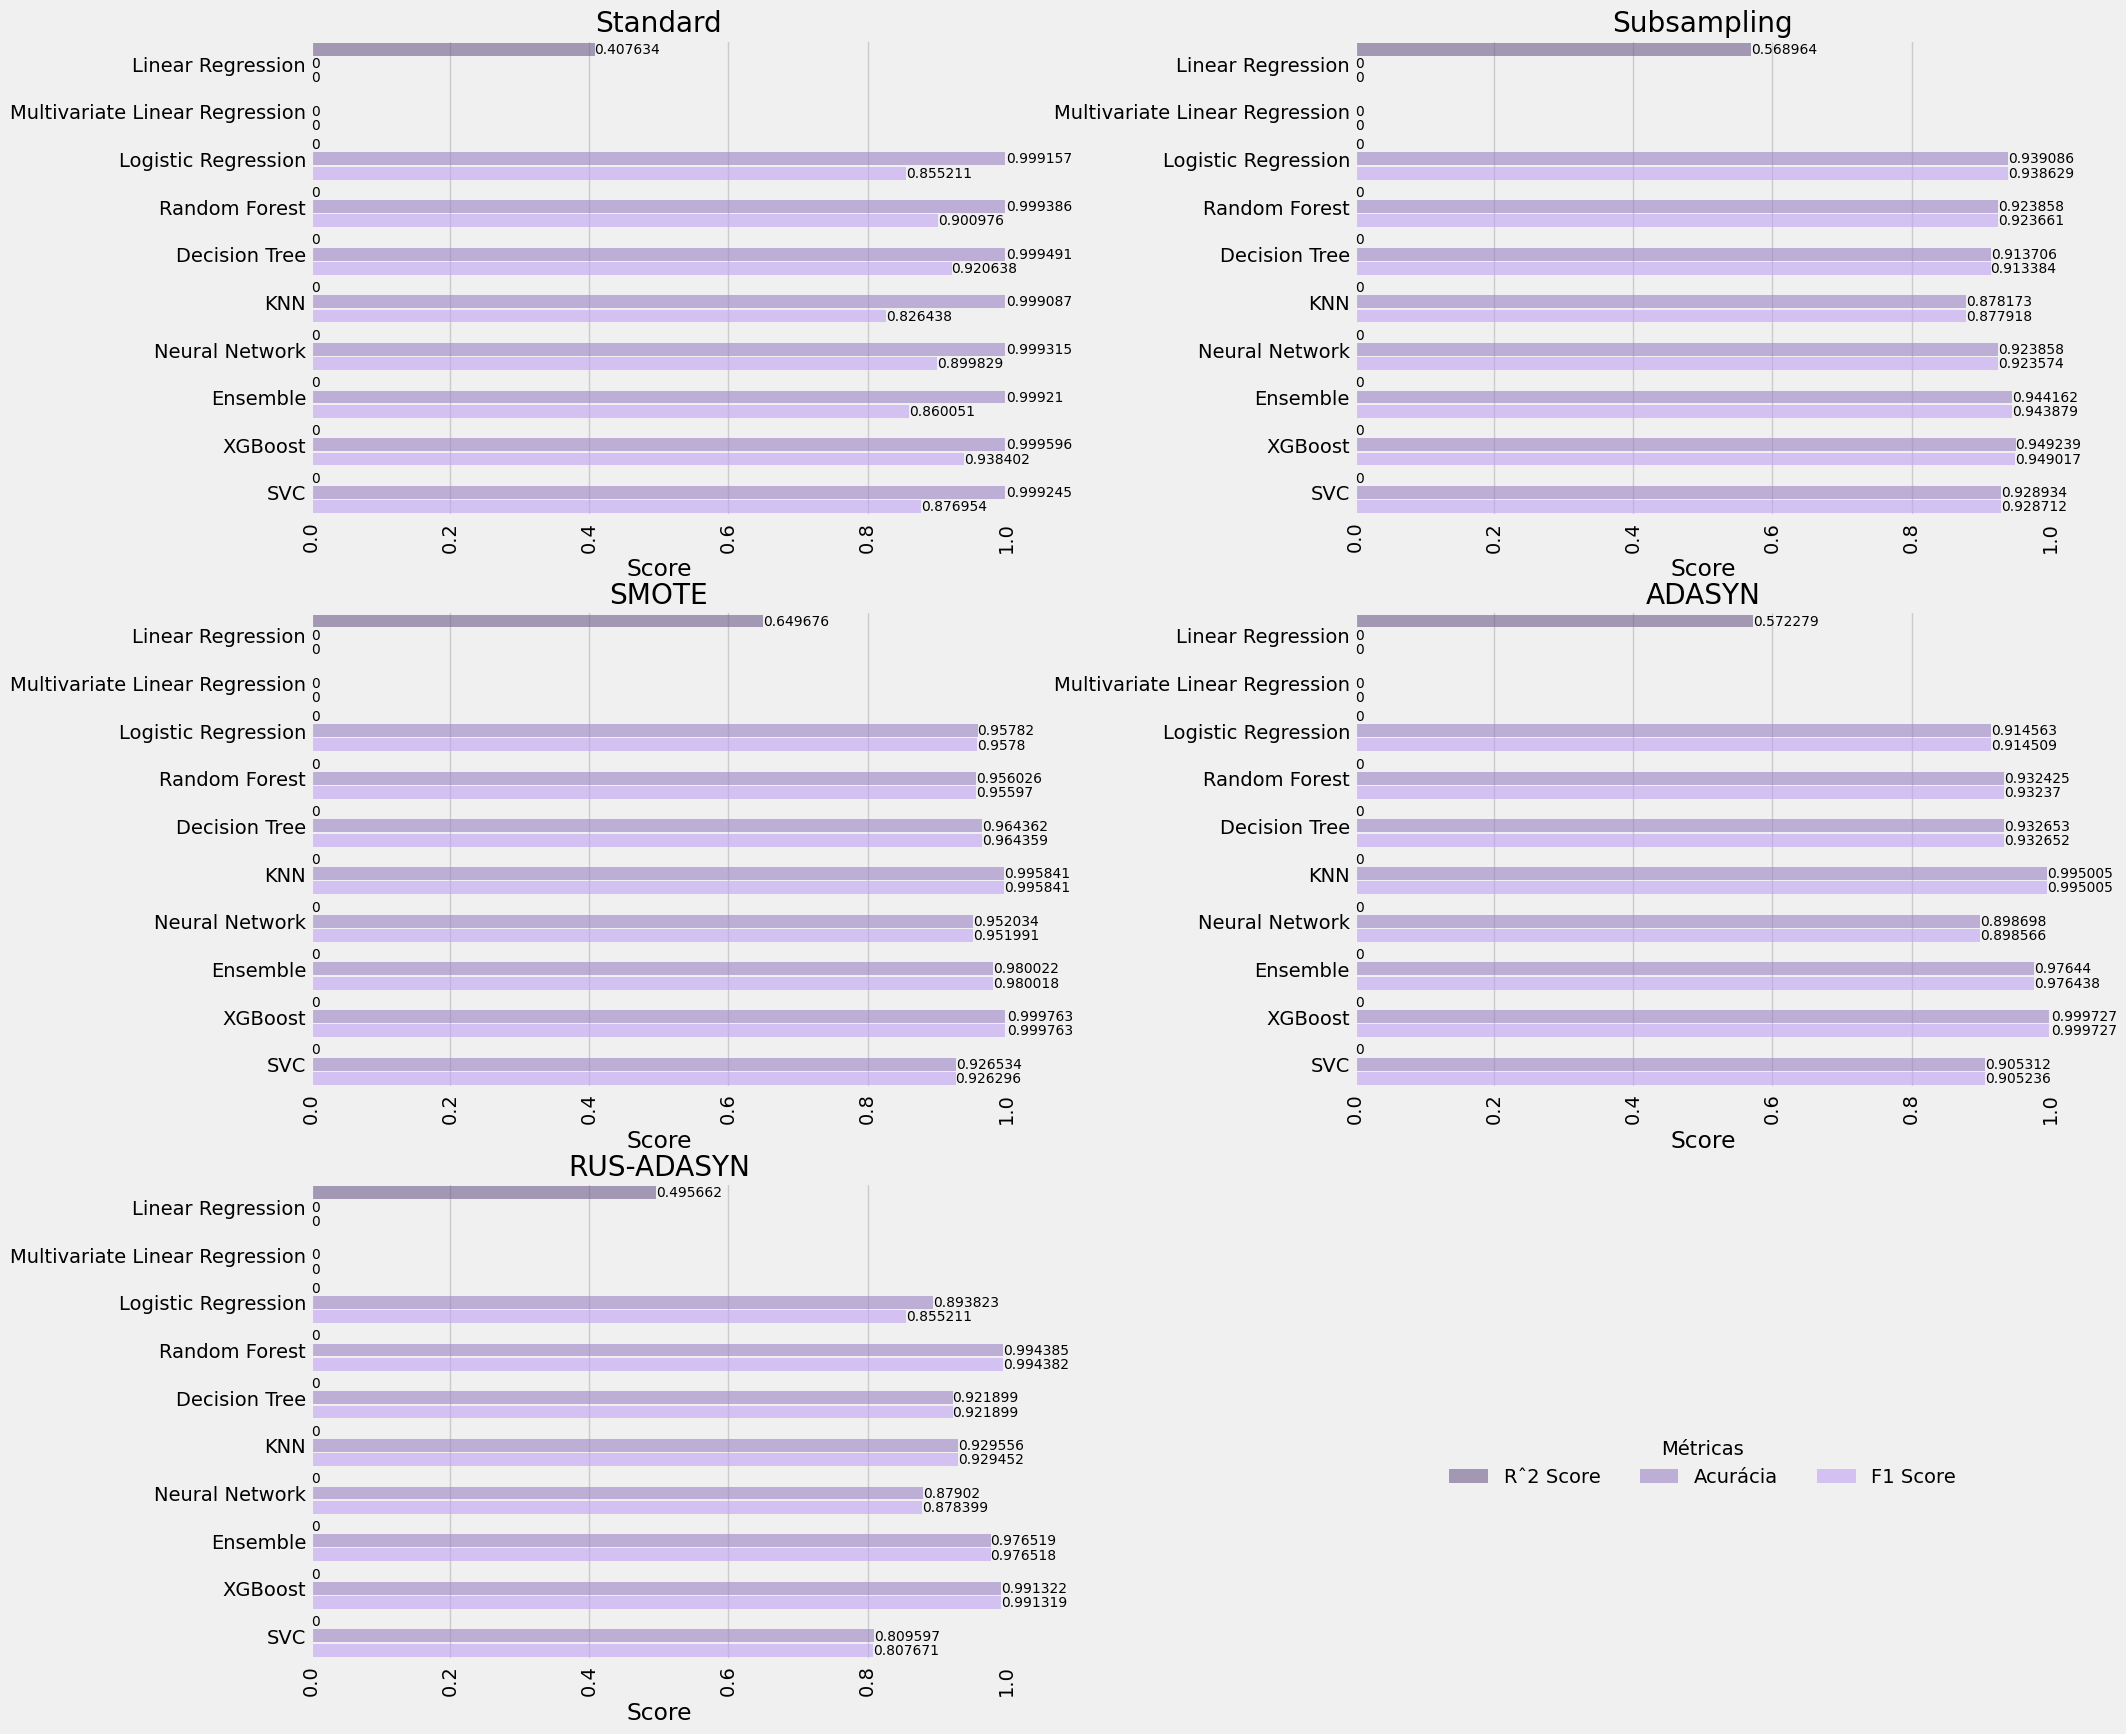

In [179]:
# creating subplots
fig, axes = plt.subplots(3, 2,figsize=(20,20))
colors = ['#6C5693', '#9879CD','#BC95FF']
sns.set_palette(sns.color_palette(colors))

# plotting columns
ax = sns.barplot(x=df_std["value"], y=df_std["model_technique"], alpha=.6, width=.9, hue=df_std["score_type"], gap=.1, ax=axes[0][0], orient = 'h')
ax = sns.barplot(x=df_sub["value"], y=df_sub["model_technique"], alpha=.6, width=.9, hue=df_sub["score_type"], gap=.1, ax=axes[0][1], orient = 'h')
ax = sns.barplot(x=df_smote["value"], y=df_smote["model_technique"], alpha=.6, width=.9, hue=df_smote["score_type"], gap=.1, ax=axes[1][0], orient = 'h')
ax = sns.barplot(x=df_ada["value"], y=df_ada["model_technique"], alpha=.6, width=.9, hue=df_ada["score_type"], gap=.1, ax=axes[1][1], orient = 'h')
ax = sns.barplot(x=df_rusada["value"], y=df_rusada["model_technique"], alpha=.6, width=.9, hue=df_rusada["score_type"], gap=.1, ax=axes[2][0], orient = 'h')
sns.move_legend(ax, "upper center", ncol=3, frameon=False, bbox_to_anchor=(2, 0.5), title='Métricas')



# Standard
axes[0][0].set_title('Standard')
axes[0][0].set(xlim=(0, 1))
axes[0][0].tick_params(axis='x', rotation=90)
axes[0][0].bar_label(axes[0][0].containers[0], fontsize=10)
axes[0][0].bar_label(axes[0][0].containers[1], fontsize=10)
axes[0][0].bar_label(axes[0][0].containers[2], fontsize=10)
axes[0][0].set(xlabel="Score", ylabel="")
axes[0][0].legend([],[], frameon=False)

# Subsampling
axes[0][1].set_title('Subsampling')
axes[0][1].set(xlim=(0, 1))
axes[0][1].tick_params(axis='x', rotation=90)
axes[0][1].bar_label(axes[0][1].containers[0], fontsize=10)
axes[0][1].bar_label(axes[0][1].containers[1], fontsize=10)
axes[0][1].bar_label(axes[0][1].containers[2], fontsize=10)
axes[0][1].set(xlabel="Score", ylabel="")
axes[0][1].legend([],[], frameon=False)

# SMOTE
axes[1][0].set_title('SMOTE')
axes[1][0].set(xlim=(0, 1))
axes[1][0].tick_params(axis='x', rotation=90)
axes[1][0].bar_label(axes[1][0].containers[0], fontsize=10)
axes[1][0].bar_label(axes[1][0].containers[1], fontsize=10)
axes[1][0].bar_label(axes[1][0].containers[2], fontsize=10)
axes[1][0].set(xlabel="Score", ylabel="")
axes[1][0].legend([],[], frameon=False)

# ADASYN
axes[1][1].set_title('ADASYN')
axes[1][1].set(xlim=(0, 1))
axes[1][1].tick_params(axis='x', rotation=90)
axes[1][1].bar_label(axes[1][1].containers[0], fontsize=10)
axes[1][1].bar_label(axes[1][1].containers[1], fontsize=10)
axes[1][1].bar_label(axes[1][1].containers[2], fontsize=10)
axes[1][1].set(xlabel="Score", ylabel="")
axes[1][1].legend([],[], frameon=False)

#RUS-ADASYN
axes[2][0].set_title('RUS-ADASYN')
axes[2][0].set(xlim=(0, 1))
axes[2][0].tick_params(axis='x', rotation=90)
axes[2][0].bar_label(axes[2][0].containers[0], fontsize=10)
axes[2][0].bar_label(axes[2][0].containers[1], fontsize=10)
axes[2][0].bar_label(axes[2][0].containers[2], fontsize=10)
axes[2][0].set(xlabel="Score", ylabel="")

fig.subplots_adjust(wspace=0.5)
fig.delaxes(axes[2][1])
# visualizing illustration
plt.show()